In [2]:
import time
import datetime
from datetime import date
import sys
import os
import gc
import tqdm
from workalendar.america import Brazil
from workalendar.europe import UnitedKingdom
from workalendar.asia import HongKong, Taiwan, Japan
from tkinter import _flatten

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

/home/hhc/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# log
class Logger(object):
    def __init__(self, fileN="Default.log"):
        self.terminal = sys.stdout
        self.log = open(fileN, "a")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def flush(self):
        pass
    
    
nowtime = datetime.datetime.now().strftime('%Y%m%d_%H%M')
# sys.stdout = Logger("log/lgb01_" + nowtime + '.log')

In [4]:
debug=False
num_rows = 10000 if debug else None

df_train = reduce_mem_usage(pd.read_csv('../input/train.csv'))
df_test = reduce_mem_usage(pd.read_csv('../input/test.csv'))
# df_trans_old = reduce_mem_usage(pd.read_csv('../input/historical_transactions.csv', nrows=num_rows))
# df_trans_new = reduce_mem_usage(pd.read_csv('../input/new_merchant_transactions.csv', nrows=num_rows))
# df_merchants = reduce_mem_usage(pd.read_csv('../input/merchants.csv'))
# df_sub_sample = reduce_mem_usage(pd.read_csv('../input/sample_submission.csv'))

print('df_train shape:', df_train.shape)
print('df_test shape:', df_test.shape)
# print('df_trans_old shape:', df_trans_old.shape)
# print('df_trans_new shape:', df_trans_new.shape)
# print('df_merchants shape:', df_merchants.shape)

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
df_train shape: (201917, 6)
df_test shape: (123623, 5)


In [5]:
df_feats_train_cnn = reduce_mem_usage(pd.read_csv('../input/df_feats_train_cnn.csv'))
df_feats_test_cnn = reduce_mem_usage(pd.read_csv('../input/df_feats_test_cnn.csv'))

Mem. usage decreased to 341.99 Mb (66.2% reduction)
Mem. usage decreased to 181.09 Mb (68.4% reduction)


In [10]:
df_feats_train = reduce_mem_usage(pd.read_csv('../input/df_feats_train_3.691.csv'))
df_feats_test = reduce_mem_usage(pd.read_csv('../input/df_feats_test_3.691.csv'))


Mem. usage decreased to 94.16 Mb (69.9% reduction)
Mem. usage decreased to 57.65 Mb (69.9% reduction)


In [11]:
df_feats_train.head()


,card_id,feature_1,feature_2,feature_3,first_active_month,outliers,target,quarter,elapsed_time,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_mean,feature_max,feature_min,feature_var,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_month_nunique,hist_month_mean,hist_month_min,hist_month_max,hist_hour_nunique,hist_hour_mean,hist_hour_min,hist_hour_max,hist_weekofyear_nunique,hist_weekofyear_mean,hist_weekofyear_min,hist_weekofyear_max,hist_weekday_mean,hist_day_nunique,hist_day_mean,hist_day_min,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_skew,hist_installments_sum,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_skew,hist_month_diff_max,hist_month_diff_min,hist_month_diff_mean,hist_month_diff_var,hist_month_diff_skew,hist_authorized_flag_mean,hist_weekend_mean,hist_category_1_mean,hist_category_2_mean,hist_category_3_mean,hist_card_id_size,hist_card_id_count,hist_price_sum,hist_price_mean,hist_price_max,hist_price_min,hist_price_var,hist_Christmas_Day_2017_mean,hist_Mothers_Day_2017_mean,hist_fathers_day_2017_mean,hist_Children_day_2017_mean,hist_Valentine_Day_2017_mean,hist_Black_Friday_2017_mean,hist_Mothers_Day_2018_mean,hist_duration_mean,hist_duration_min,hist_duration_max,hist_duration_var,hist_duration_skew,hist_amount_month_ratio_mean,hist_amount_month_ratio_min,hist_amount_month_ratio_max,hist_amount_month_ratio_var,hist_amount_month_ratio_skew,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_purchase_date_uptomin,new_subsector_id_nunique,new_merchant_id_nunique,new_merchant_category_id_nunique,new_month_mean,new_month_min,new_month_max,new_hour_nunique,new_hour_mean,new_hour_min,new_hour_max,new_weekofyear_nunique,new_weekofyear_mean,new_weekofyear_min,new_weekofyear_max,new_weekday_mean,new_weekday_min,new_weekday_max,new_day_nunique,new_day_mean,new_day_min,new_day_max,new_purchase_amount_sum,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_mean,new_purchase_amount_var,new_purchase_amount_skew,new_installments_sum,new_installments_max,new_installments_mean,new_installments_var,new_installments_skew,new_purchase_date_max,new_purchase_date_min,new_month_lag_max,new_month_lag_min,new_month_lag_mean,new_month_lag_var,new_month_lag_skew,new_month_diff_mean,new_month_diff_var,new_month_diff_skew,new_weekend_mean,new_category_1_mean,new_category_2_mean,new_category_3_mean,new_card_id_size,new_card_id_count,new_price_mean,new_price_max,new_price_min,new_price_var,new_Christmas_Day_2017_mean,new_Children_day_2017_mean,new_Black_Friday_2017_mean,new_Mothers_Day_2018_mean,new_duration_mean,new_duration_min,new_duration_max,new_duration_var,new_duration_skew,new_amount_month_ratio_mean,new_amount_month_ratio_min,new_amount_month_ratio_max,new_amount_month_ratio_var,new_amount_month_ratio_skew,new_category_2_mean_mean,new_category_3_mean_mean,new_purchase_date_diff,new_purchase_date_average,new_purchase_date_uptonow,new_purchase_date_uptomin,hist_first_buy,hist_last_buy,new_first_buy,new_last_buy,card_id_total,card_id_cnt_total,card_id_cnt_ratio,purchase_amount_total,purchase_amount_mean,purchase_amount_max,purchase_amount_min,purchase_amount_ratio,month_diff_mean,month_diff_ratio,month_lag_mean,month_lag_max,month_lag_min,category_1_mean,installments_total,installments_mean,installments_max,installments_ratio,price_total,price_mean,price_max,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio
0,C_ID_92a2005557,0.013145,0.008751,0.011429,2017-06-01,0.

In [12]:
lst_months_old = [m for m in range(201701, 201713, 1)] + [m for m in range(201801, 201803, 1)]
lst_months_new = [m for m in range(201703, 201713, 1)] + [m for m in range(201801, 201805, 1)]

for month in lst_months_old:
    df_feats_train = df_feats_train.merge(df_feats_train_cnn[df_feats_train_cnn['year_month'] == month][['card_id', 'old_purchase_amount_sum']], on=['card_id'], how='left')
    df_feats_test = df_feats_test.merge(df_feats_test_cnn[df_feats_test_cnn['year_month'] == month][['card_id', 'old_purchase_amount_sum']], on=['card_id'], how='left')
    df_feats_train['old_purchase_amount_sum_' + str(month)] = df_feats_train['old_purchase_amount_sum']
    df_feats_test['old_purchase_amount_sum_' + str(month)] = df_feats_test['old_purchase_amount_sum']
    del df_feats_train['old_purchase_amount_sum'], df_feats_test['old_purchase_amount_sum']
    gc.collect()
    
# for month in lst_months_new:
#     df_feats_train = df_feats_train.merge(df_feats_train_cnn[df_feats_train_cnn['year_month'] == month][['card_id', 'new_purchase_amount_sum']], on=['card_id'], how='left')
#     df_feats_test = df_feats_test.merge(df_feats_test_cnn[df_feats_test_cnn['year_month'] == month][['card_id', 'new_purchase_amount_sum']], on=['card_id'], how='left')
#     df_feats_train['new_purchase_amount_sum_' + str(month)] = df_feats_train['new_purchase_amount_sum']
#     df_feats_test['new_purchase_amount_sum_' + str(month)] = df_feats_test['new_purchase_amount_sum']
#     del df_feats_train['new_purchase_amount_sum'], df_feats_test['new_purchase_amount_sum']
#     gc.collect()

In [13]:
for df in [df_feats_train, df_feats_test]:
    df['old_purchase_amount_sum_ratio_1'] = df['old_purchase_amount_sum_201802'] / df['old_purchase_amount_sum_201801']
    df['old_purchase_amount_sum_ratio_2'] = (df['old_purchase_amount_sum_201802'] + df['old_purchase_amount_sum_201801']) / (df['old_purchase_amount_sum_201712'] + df['old_purchase_amount_sum_201711'])
    df['old_purchase_amount_sum_ratio_3'] = (df['old_purchase_amount_sum_201802'] + df['old_purchase_amount_sum_201801']) / (df['old_purchase_amount_sum_201712'] + df['old_purchase_amount_sum_201711'] + df['old_purchase_amount_sum_201710'] + df['old_purchase_amount_sum_201709'])
    df['old_purchase_amount_sum_ratio_4'] = (df['old_purchase_amount_sum_201802'] + df['old_purchase_amount_sum_201801'] + df['old_purchase_amount_sum_201712']) / (df['old_purchase_amount_sum_201711'] + df['old_purchase_amount_sum_201710'] + df['old_purchase_amount_sum_201709'])
    df['old_purchase_amount_sum_ratio_5'] = (df['old_purchase_amount_sum_201802'] + df['old_purchase_amount_sum_201801'] + df['old_purchase_amount_sum_201712']) / (df['old_purchase_amount_sum_201711'] + df['old_purchase_amount_sum_201710'] + df['old_purchase_amount_sum_201709'] + df['old_purchase_amount_sum_201708'] + df['old_purchase_amount_sum_201707'] + df['old_purchase_amount_sum_201706'])


In [14]:
df_feats_train.head()

,card_id,feature_1,feature_2,feature_3,first_active_month,outliers,target,quarter,elapsed_time,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_mean,feature_max,feature_min,feature_var,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_month_nunique,hist_month_mean,hist_month_min,hist_month_max,hist_hour_nunique,hist_hour_mean,hist_hour_min,hist_hour_max,hist_weekofyear_nunique,hist_weekofyear_mean,hist_weekofyear_min,hist_weekofyear_max,hist_weekday_mean,hist_day_nunique,hist_day_mean,hist_day_min,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_skew,hist_installments_sum,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_skew,hist_month_diff_max,hist_month_diff_min,hist_month_diff_mean,hist_month_diff_var,hist_month_diff_skew,hist_authorized_flag_mean,hist_weekend_mean,hist_category_1_mean,hist_category_2_mean,hist_category_3_mean,hist_card_id_size,hist_card_id_count,hist_price_sum,hist_price_mean,hist_price_max,hist_price_min,hist_price_var,hist_Christmas_Day_2017_mean,hist_Mothers_Day_2017_mean,hist_fathers_day_2017_mean,hist_Children_day_2017_mean,hist_Valentine_Day_2017_mean,hist_Black_Friday_2017_mean,hist_Mothers_Day_2018_mean,hist_duration_mean,hist_duration_min,hist_duration_max,hist_duration_var,hist_duration_skew,hist_amount_month_ratio_mean,hist_amount_month_ratio_min,hist_amount_month_ratio_max,hist_amount_month_ratio_var,hist_amount_month_ratio_skew,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_purchase_date_uptomin,new_subsector_id_nunique,new_merchant_id_nunique,new_merchant_category_id_nunique,new_month_mean,new_month_min,new_month_max,new_hour_nunique,new_hour_mean,new_hour_min,new_hour_max,new_weekofyear_nunique,new_weekofyear_mean,new_weekofyear_min,new_weekofyear_max,new_weekday_mean,new_weekday_min,new_weekday_max,new_day_nunique,new_day_mean,new_day_min,new_day_max,new_purchase_amount_sum,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_mean,new_purchase_amount_var,new_purchase_amount_skew,new_installments_sum,new_installments_max,new_installments_mean,new_installments_var,new_installments_skew,new_purchase_date_max,new_purchase_date_min,new_month_lag_max,new_month_lag_min,new_month_lag_mean,new_month_lag_var,new_month_lag_skew,new_month_diff_mean,new_month_diff_var,new_month_diff_skew,new_weekend_mean,new_category_1_mean,new_category_2_mean,new_category_3_mean,new_card_id_size,new_card_id_count,new_price_mean,new_price_max,new_price_min,new_price_var,new_Christmas_Day_2017_mean,new_Children_day_2017_mean,new_Black_Friday_2017_mean,new_Mothers_Day_2018_mean,new_duration_mean,new_duration_min,new_duration_max,new_duration_var,new_duration_skew,new_amount_month_ratio_mean,new_amount_month_ratio_min,new_amount_month_ratio_max,new_amount_month_ratio_var,new_amount_month_ratio_skew,new_category_2_mean_mean,new_category_3_mean_mean,new_purchase_date_diff,new_purchase_date_average,new_purchase_date_uptonow,new_purchase_date_uptomin,hist_first_buy,hist_last_buy,new_first_buy,new_last_buy,card_id_total,card_id_cnt_total,card_id_cnt_ratio,purchase_amount_total,purchase_amount_mean,purchase_amount_max,purchase_amount_min,purchase_amount_ratio,month_diff_mean,month_diff_ratio,month_lag_mean,month_lag_max,month_lag_min,category_1_mean,installments_total,installments_mean,installments_max,installments_ratio,price_total,price_mean,price_max,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio,old_purchase_amount_sum_201701,old_purchase_amount_sum_201

# Model

In [18]:
# rmse
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:1000].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(14, 60))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(feat_impt_png)
    
    
def kfold_lightgbm(train_df, test_df, num_folds, stratified=False, debug=False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]
    
    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # set data structure
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               free_raw_data=False)

        # params optimized by optuna
        params = {
            'task': 'train',
            'boosting': 'goss',
            'objective': 'regression',
            'metric': 'mae',
            'learning_rate': 0.004,
            'subsample': 0.9855232997390695,
            'max_depth': 8,
            'top_rate': 0.9064148448434349,
            'num_leaves': 63,
            'min_child_weight': 41.9612869171337,
            'other_rate': 0.0721768246018207,
            'reg_alpha': 9.677537745007898,
            'colsample_bytree': 0.5665320670155495,
            'min_split_gain': 9.820197773625843,
            'reg_lambda': 8.2532317400459,
            'min_data_in_leaf': 21,
            'verbose': -1,
            'seed': int(2 ** n_fold),
            'bagging_seed': int(2 ** n_fold),
            'drop_seed': int(2 ** n_fold)
        }

        reg = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_test],
#             valid_names=['train', 'test'],
            num_boost_round=10000,
            early_stopping_rounds=200,
            verbose_eval=100
        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(
            reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    
    local_rmse = rmse(train_df['target'], oof_preds)
    print('local rmse:', local_rmse)
    
    submission_file_name = "result/lgb04_sub_"+ nowtime + '_' + str(local_rmse) +".csv"
    feat_impt_png = 'result/lgb04_impt_'+ nowtime + '_' + str(local_rmse) +'.png'

    
    if not debug:
        # save submission file
        test_df.loc[:, 'target'] = sub_preds
        test_df = test_df.reset_index()
        test_df[['card_id', 'target']].to_csv(submission_file_name, index=False)
        
    # display importances
    display_importances(feature_importance_df)

In [ ]:
FEATS_EXCLUDED = ['first_active_month', 'target', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
                  'OOF_PRED', 'month_0']

nowtime = datetime.datetime.now().strftime('%Y%m%d_%H%M')

# kfold_lightgbm(df_feats_train, df_feats_test, num_folds=11, stratified=True, debug=False)
num_folds=11
stratified=True
debug=False
print("Starting LightGBM. Train shape: {}, test shape: {}".format(df_feats_train.shape, df_feats_test.shape))

# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=326)
else:
    folds = KFold(n_splits=num_folds, shuffle=True, random_state=326)

# Create arrays and dataframes to store results
oof_preds = np.zeros(df_feats_train.shape[0])
sub_preds = np.zeros(df_feats_test.shape[0])
feature_importance_df = pd.DataFrame()
# feats = [f for f in df_feats_train.columns if f not in FEATS_EXCLUDED]
feats = feats_sub

# k-fold
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_feats_train[feats], df_feats_train['outliers'])):
    train_x, train_y = df_feats_train[feats].iloc[train_idx], df_feats_train['target'].iloc[train_idx]
    valid_x, valid_y = df_feats_train[feats].iloc[valid_idx], df_feats_train['target'].iloc[valid_idx]

    # set data structure
    lgb_train = lgb.Dataset(train_x,
                            label=train_y,
                            free_raw_data=False)
    lgb_test = lgb.Dataset(valid_x,
                           label=valid_y,
                           free_raw_data=False)

    # params optimized by optuna
#     params = {
#         'task': 'train',
#         'boosting': 'goss',
#         'objective': 'regression',
#         'metric': 'mae',
#         'learning_rate': 0.004,
#         'subsample': 0.9855232997390695,
#         'max_depth': 7,
#         'top_rate': 0.9064148448434349,
#         'num_leaves': 63,
#         'min_child_weight': 41.9612869171337,
#         'other_rate': 0.0721768246018207,
#         'reg_alpha': 9.677537745007898,
#         'colsample_bytree': 0.5665320670155495,
#         'min_split_gain': 9.820197773625843,
#         'reg_lambda': 8.2532317400459,
#         'min_data_in_leaf': 21,
#         'verbose': -1,
#         'seed': int(2 ** n_fold),
#         'bagging_seed': int(2 ** n_fold),
#         'drop_seed': int(2 ** n_fold)
#     }

    params = {
        'task': 'train',
        'boosting': 'gbdt',
        'objective': 'regression',
        'metric': 'mape',
        'learning_rate': 0.004,
        'subsample': 0.98,
        'max_depth': 9,
        'num_leaves': 200,
        'verbose': -1,
    }
    
    reg = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
#             valid_names=['train', 'test'],
        num_boost_round=10000,
        early_stopping_rounds=200,
        verbose_eval=100
    )

    oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
    sub_preds += reg.predict(df_feats_test[feats], num_iteration=reg.best_iteration) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = np.log1p(
        reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))

    del reg, train_x, train_y, valid_x, valid_y
    gc.collect()


local_rmse = rmse(df_feats_train['target'], oof_preds)
print('local rmse:', local_rmse)

submission_file_name = "result/lgb04_sub_"+ nowtime + '_' + str(local_rmse) +".csv"
feat_impt_png = 'result/lgb04_impt_'+ nowtime + '_' + str(local_rmse) +'.png'


if not debug:
    # save submission file
    df_feats_test.loc[:, 'target'] = sub_preds
#     df_feats_test = df_feats_test.reset_index()
    df_feats_test[['card_id', 'target']].to_csv(submission_file_name, index=False)

# display importances
display_importances(feature_importance_df)

Starting LightGBM. Train shape: (201917, 222), test shape: (123623, 224)
Training until validation scores don't improve for 200 rounds.
[100]	training's mape: 0.716054	valid_1's mape: 0.718156
[200]	training's mape: 0.721524	valid_1's mape: 0.727945
Early stopping, best iteration is:
[83]	training's mape: 0.71641	valid_1's mape: 0.717742
Fold  1 RMSE : 3.763737
Training until validation scores don't improve for 200 rounds.
[100]	training's mape: 0.715451	valid_1's mape: 0.720864
[200]	training's mape: 0.720497	valid_1's mape: 0.731503
Early stopping, best iteration is:
[75]	training's mape: 0.716378	valid_1's mape: 0.720431
Fold  2 RMSE : 3.766091
Training until validation scores don't improve for 200 rounds.
[100]	training's mape: 0.715682	valid_1's mape: 0.721524
[200]	training's mape: 0.720972	valid_1's mape: 0.733296
Early stopping, best iteration is:
[73]	training's mape: 0.716558	valid_1's mape: 0.720948
Fold  3 RMSE : 3.770866
Training until validation scores don't improve for 2

In [36]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:160].index
feats_sub = cols.values.tolist()

In [ ]:
df_feats_test['target'].hist(bins=100)

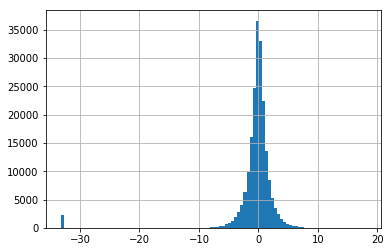

In [33]:
df_feats_train['target'].hist(bins=100)

## XGB

In [100]:
def kfold_xgb(df_train, df_test, num_folds):
    
    df_train_columns = [f for f in df_train.columns if f not in FEATS_EXCLUDED]
    target = df_train['target']
    
    # 构造XGBRegressor模型
    model = xgb.XGBRegressor(
        max_depth=7,
        learning_rate=0.01,
        n_estimators=10000,
        silent=True,
        objective='reg:linear',
        eval_metric='rmse',
        nthread=-1,
        gamma=0,
        min_child_weight=1,
        max_delta_step=0,
        subsample=1,
        colsample_bytree=0.7,
        colsample_bylevel=1,
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        seed=1440,
        missing=None,
        verbose=True
    )

    folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=4590)
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    plt.figure(figsize=(20,4))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train[df_train_columns],df_train['outliers'].values)):
        print("fold {}".format(fold_))

        clf = model.fit(df_train.iloc[trn_idx][df_train_columns], target.iloc[trn_idx], 
                        eval_set = [(df_train.iloc[trn_idx][df_train_columns], target.iloc[trn_idx]),
                                    (df_train.iloc[val_idx][df_train_columns], target.iloc[val_idx])],
                         early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns])

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = df_train_columns
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(df_test[df_train_columns]) / folds.n_splits

        num_realy = len(model.evals_result_['validation_0']['rmse'])
        plt.subplot(1,folds.n_splits,fold_+1)
        plt.plot(range(num_realy),model.evals_result_['validation_0']['rmse'])
        plt.plot(range(num_realy),model.evals_result_['validation_1']['rmse'])
        plt.legend(['training','valid'])

    local_rmse = np.sqrt(mean_squared_error(oof, target))
    print('local rmse:', local_rmse)
    plt.show()
    
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:1000].index)

    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(14,60))
    sns.barplot(x="importance",
                y="Feature",
                data=best_features.sort_values(by="importance",
                                               ascending=False))
    plt.title('XGBoost Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('result/xgb02_impt_'+ nowtime + '-' +str(local_rmse) +'.png')
    
    sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
    sub_df["target"] = predictions
    sub_df.to_csv("result/xgb02_sub_"+ nowtime + '-' + str(local_rmse) +".csv", index=False)

fold 0
[0]	validation_0-rmse:3.9458	validation_1-rmse:3.95841
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:3.93985	validation_1-rmse:3.95349
[2]	validation_0-rmse:3.9338	validation_1-rmse:3.94851
[3]	validation_0-rmse:3.92818	validation_1-rmse:3.94384
[4]	validation_0-rmse:3.92244	validation_1-rmse:3.93925
[5]	validation_0-rmse:3.91717	validation_1-rmse:3.93488
[6]	validation_0-rmse:3.91163	validation_1-rmse:3.93058
[7]	validation_0-rmse:3.90634	validation_1-rmse:3.92607
[8]	validation_0-rmse:3.90089	validation_1-rmse:3.92165
[9]	validation_0-rmse:3.89553	validation_1-rmse:3.91712
[10]	validation_0-rmse:3.89049	validation_1-rmse:3.91305
[11]	validation_0-rmse:3.88563	validation_1-rmse:3.90918
[12]	validation_0-rmse:3.88043	validation_1-rmse:3.90524
[13]	validation_0-rmse:3.87535	validation_1-rmse:3.90107
[14]	validation_0-rmse:3.87043	validation_1-rms

[141]	validation_0-rmse:3.5576	validation_1-rmse:3.7032
[142]	validation_0-rmse:3.55621	validation_1-rmse:3.70292
[143]	validation_0-rmse:3.555	validation_1-rmse:3.70249
[144]	validation_0-rmse:3.55369	validation_1-rmse:3.70201
[145]	validation_0-rmse:3.55239	validation_1-rmse:3.70172
[146]	validation_0-rmse:3.55099	validation_1-rmse:3.701
[147]	validation_0-rmse:3.54976	validation_1-rmse:3.70072
[148]	validation_0-rmse:3.5482	validation_1-rmse:3.70041
[149]	validation_0-rmse:3.54693	validation_1-rmse:3.7
[150]	validation_0-rmse:3.54558	validation_1-rmse:3.69937
[151]	validation_0-rmse:3.54435	validation_1-rmse:3.69866
[152]	validation_0-rmse:3.543	validation_1-rmse:3.6981
[153]	validation_0-rmse:3.54194	validation_1-rmse:3.6978
[154]	validation_0-rmse:3.54077	validation_1-rmse:3.69738
[155]	validation_0-rmse:3.53954	validation_1-rmse:3.69698
[156]	validation_0-rmse:3.53829	validation_1-rmse:3.69651
[157]	validation_0-rmse:3.53713	validation_1-rmse:3.69625
[158]	validation_0-rmse:3.535

[283]	validation_0-rmse:3.41808	validation_1-rmse:3.6743
[284]	validation_0-rmse:3.41735	validation_1-rmse:3.67419
[285]	validation_0-rmse:3.41637	validation_1-rmse:3.67418
[286]	validation_0-rmse:3.41583	validation_1-rmse:3.67412
[287]	validation_0-rmse:3.41524	validation_1-rmse:3.67414
[288]	validation_0-rmse:3.41464	validation_1-rmse:3.67413
[289]	validation_0-rmse:3.41414	validation_1-rmse:3.67403
[290]	validation_0-rmse:3.41337	validation_1-rmse:3.674
[291]	validation_0-rmse:3.41278	validation_1-rmse:3.67404
[292]	validation_0-rmse:3.41232	validation_1-rmse:3.67392
[293]	validation_0-rmse:3.41158	validation_1-rmse:3.67402
[294]	validation_0-rmse:3.41097	validation_1-rmse:3.67401
[295]	validation_0-rmse:3.41011	validation_1-rmse:3.674
[296]	validation_0-rmse:3.40954	validation_1-rmse:3.67397
[297]	validation_0-rmse:3.40865	validation_1-rmse:3.67375
[298]	validation_0-rmse:3.40815	validation_1-rmse:3.67366
[299]	validation_0-rmse:3.4077	validation_1-rmse:3.6736
[300]	validation_0-rm

[425]	validation_0-rmse:3.34387	validation_1-rmse:3.66896
[426]	validation_0-rmse:3.34355	validation_1-rmse:3.66894
[427]	validation_0-rmse:3.34301	validation_1-rmse:3.66893
[428]	validation_0-rmse:3.34259	validation_1-rmse:3.66893
[429]	validation_0-rmse:3.3419	validation_1-rmse:3.6689
[430]	validation_0-rmse:3.34141	validation_1-rmse:3.66896
[431]	validation_0-rmse:3.34101	validation_1-rmse:3.66885
[432]	validation_0-rmse:3.34043	validation_1-rmse:3.66878
[433]	validation_0-rmse:3.34009	validation_1-rmse:3.66875
[434]	validation_0-rmse:3.33963	validation_1-rmse:3.66877
[435]	validation_0-rmse:3.3392	validation_1-rmse:3.66881
[436]	validation_0-rmse:3.3388	validation_1-rmse:3.66877
[437]	validation_0-rmse:3.33812	validation_1-rmse:3.66868
[438]	validation_0-rmse:3.33784	validation_1-rmse:3.66867
[439]	validation_0-rmse:3.33748	validation_1-rmse:3.66867
[440]	validation_0-rmse:3.33708	validation_1-rmse:3.66871
[441]	validation_0-rmse:3.33641	validation_1-rmse:3.66876
[442]	validation_0

[567]	validation_0-rmse:3.29476	validation_1-rmse:3.66782
[568]	validation_0-rmse:3.29442	validation_1-rmse:3.66782
[569]	validation_0-rmse:3.29418	validation_1-rmse:3.66777
[570]	validation_0-rmse:3.29403	validation_1-rmse:3.66778
[571]	validation_0-rmse:3.29392	validation_1-rmse:3.66778
[572]	validation_0-rmse:3.29376	validation_1-rmse:3.66781
[573]	validation_0-rmse:3.29344	validation_1-rmse:3.66776
[574]	validation_0-rmse:3.29294	validation_1-rmse:3.66772
[575]	validation_0-rmse:3.29274	validation_1-rmse:3.66774
[576]	validation_0-rmse:3.29243	validation_1-rmse:3.66777
[577]	validation_0-rmse:3.29218	validation_1-rmse:3.66769
[578]	validation_0-rmse:3.29188	validation_1-rmse:3.66771
[579]	validation_0-rmse:3.29152	validation_1-rmse:3.66771
[580]	validation_0-rmse:3.29137	validation_1-rmse:3.66771
[581]	validation_0-rmse:3.29099	validation_1-rmse:3.66777
[582]	validation_0-rmse:3.29086	validation_1-rmse:3.66777
[583]	validation_0-rmse:3.29058	validation_1-rmse:3.66781
[584]	validati

[709]	validation_0-rmse:3.25549	validation_1-rmse:3.66762
Stopping. Best iteration:
[609]	validation_0-rmse:3.28375	validation_1-rmse:3.66692

fold 1
[0]	validation_0-rmse:3.94562	validation_1-rmse:3.95798
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:3.93979	validation_1-rmse:3.95332
[2]	validation_0-rmse:3.93387	validation_1-rmse:3.94828
[3]	validation_0-rmse:3.9281	validation_1-rmse:3.94353
[4]	validation_0-rmse:3.92232	validation_1-rmse:3.93883
[5]	validation_0-rmse:3.91696	validation_1-rmse:3.93439
[6]	validation_0-rmse:3.91146	validation_1-rmse:3.9301
[7]	validation_0-rmse:3.9062	validation_1-rmse:3.92584
[8]	validation_0-rmse:3.90081	validation_1-rmse:3.92159
[9]	validation_0-rmse:3.89542	validation_1-rmse:3.91743
[10]	validation_0-rmse:3.89038	validation_1-rmse:3.91348
[11]	validation_0-rmse:3.88537	validation_1-rmse:3.90977
[12]	validation_0-r

[139]	validation_0-rmse:3.56598	validation_1-rmse:3.70391
[140]	validation_0-rmse:3.56463	validation_1-rmse:3.70342
[141]	validation_0-rmse:3.56351	validation_1-rmse:3.703
[142]	validation_0-rmse:3.5623	validation_1-rmse:3.70223
[143]	validation_0-rmse:3.56113	validation_1-rmse:3.70186
[144]	validation_0-rmse:3.55967	validation_1-rmse:3.7014
[145]	validation_0-rmse:3.55824	validation_1-rmse:3.70092
[146]	validation_0-rmse:3.5571	validation_1-rmse:3.70059
[147]	validation_0-rmse:3.55579	validation_1-rmse:3.70019
[148]	validation_0-rmse:3.55422	validation_1-rmse:3.69999
[149]	validation_0-rmse:3.55294	validation_1-rmse:3.69972
[150]	validation_0-rmse:3.5517	validation_1-rmse:3.6993
[151]	validation_0-rmse:3.55046	validation_1-rmse:3.6989
[152]	validation_0-rmse:3.54921	validation_1-rmse:3.69864
[153]	validation_0-rmse:3.54814	validation_1-rmse:3.69829
[154]	validation_0-rmse:3.54691	validation_1-rmse:3.69803
[155]	validation_0-rmse:3.54586	validation_1-rmse:3.69781
[156]	validation_0-rms

[281]	validation_0-rmse:3.43786	validation_1-rmse:3.67378
[282]	validation_0-rmse:3.43716	validation_1-rmse:3.67378
[283]	validation_0-rmse:3.43656	validation_1-rmse:3.67357
[284]	validation_0-rmse:3.4361	validation_1-rmse:3.6735
[285]	validation_0-rmse:3.43546	validation_1-rmse:3.67349
[286]	validation_0-rmse:3.43494	validation_1-rmse:3.67332
[287]	validation_0-rmse:3.43426	validation_1-rmse:3.67323
[288]	validation_0-rmse:3.43367	validation_1-rmse:3.67311
[289]	validation_0-rmse:3.43298	validation_1-rmse:3.67307
[290]	validation_0-rmse:3.43226	validation_1-rmse:3.67286
[291]	validation_0-rmse:3.4315	validation_1-rmse:3.67263
[292]	validation_0-rmse:3.43101	validation_1-rmse:3.67252
[293]	validation_0-rmse:3.43029	validation_1-rmse:3.67259
[294]	validation_0-rmse:3.42954	validation_1-rmse:3.6726
[295]	validation_0-rmse:3.42905	validation_1-rmse:3.67249
[296]	validation_0-rmse:3.42839	validation_1-rmse:3.67243
[297]	validation_0-rmse:3.42763	validation_1-rmse:3.67242
[298]	validation_0

[423]	validation_0-rmse:3.36289	validation_1-rmse:3.66848
[424]	validation_0-rmse:3.36237	validation_1-rmse:3.66851
[425]	validation_0-rmse:3.36192	validation_1-rmse:3.66843
[426]	validation_0-rmse:3.36158	validation_1-rmse:3.66836
[427]	validation_0-rmse:3.36124	validation_1-rmse:3.66835
[428]	validation_0-rmse:3.36072	validation_1-rmse:3.66829
[429]	validation_0-rmse:3.36047	validation_1-rmse:3.66823
[430]	validation_0-rmse:3.36021	validation_1-rmse:3.6682
[431]	validation_0-rmse:3.35986	validation_1-rmse:3.66823
[432]	validation_0-rmse:3.35937	validation_1-rmse:3.66817
[433]	validation_0-rmse:3.35897	validation_1-rmse:3.66809
[434]	validation_0-rmse:3.35844	validation_1-rmse:3.66809
[435]	validation_0-rmse:3.35799	validation_1-rmse:3.66804
[436]	validation_0-rmse:3.35751	validation_1-rmse:3.66789
[437]	validation_0-rmse:3.35715	validation_1-rmse:3.6679
[438]	validation_0-rmse:3.35681	validation_1-rmse:3.66788
[439]	validation_0-rmse:3.35645	validation_1-rmse:3.66787
[440]	validation

[565]	validation_0-rmse:3.31735	validation_1-rmse:3.66677
[566]	validation_0-rmse:3.31686	validation_1-rmse:3.66669
[567]	validation_0-rmse:3.31666	validation_1-rmse:3.66672
[568]	validation_0-rmse:3.31635	validation_1-rmse:3.66679
[569]	validation_0-rmse:3.31585	validation_1-rmse:3.66681
[570]	validation_0-rmse:3.31559	validation_1-rmse:3.66682
[571]	validation_0-rmse:3.31507	validation_1-rmse:3.66682
[572]	validation_0-rmse:3.31498	validation_1-rmse:3.66685
[573]	validation_0-rmse:3.31471	validation_1-rmse:3.66685
[574]	validation_0-rmse:3.31444	validation_1-rmse:3.66684
[575]	validation_0-rmse:3.31387	validation_1-rmse:3.66691
[576]	validation_0-rmse:3.31369	validation_1-rmse:3.66692
[577]	validation_0-rmse:3.31336	validation_1-rmse:3.66689
[578]	validation_0-rmse:3.31324	validation_1-rmse:3.66688
[579]	validation_0-rmse:3.31291	validation_1-rmse:3.66686
[580]	validation_0-rmse:3.31235	validation_1-rmse:3.66685
[581]	validation_0-rmse:3.31204	validation_1-rmse:3.66686
[582]	validati

[37]	validation_0-rmse:3.77827	validation_1-rmse:3.80728
[38]	validation_0-rmse:3.77479	validation_1-rmse:3.80441
[39]	validation_0-rmse:3.77148	validation_1-rmse:3.80171
[40]	validation_0-rmse:3.76819	validation_1-rmse:3.79907
[41]	validation_0-rmse:3.76503	validation_1-rmse:3.79664
[42]	validation_0-rmse:3.76158	validation_1-rmse:3.79397
[43]	validation_0-rmse:3.75827	validation_1-rmse:3.79146
[44]	validation_0-rmse:3.75516	validation_1-rmse:3.78905
[45]	validation_0-rmse:3.75205	validation_1-rmse:3.78656
[46]	validation_0-rmse:3.74877	validation_1-rmse:3.78419
[47]	validation_0-rmse:3.7457	validation_1-rmse:3.78199
[48]	validation_0-rmse:3.74261	validation_1-rmse:3.77969
[49]	validation_0-rmse:3.73973	validation_1-rmse:3.77772
[50]	validation_0-rmse:3.73688	validation_1-rmse:3.77562
[51]	validation_0-rmse:3.73384	validation_1-rmse:3.7735
[52]	validation_0-rmse:3.73109	validation_1-rmse:3.77141
[53]	validation_0-rmse:3.72816	validation_1-rmse:3.76938
[54]	validation_0-rmse:3.72535	va

[180]	validation_0-rmse:3.52157	validation_1-rmse:3.65156
[181]	validation_0-rmse:3.52034	validation_1-rmse:3.65154
[182]	validation_0-rmse:3.51923	validation_1-rmse:3.65127
[183]	validation_0-rmse:3.51834	validation_1-rmse:3.651
[184]	validation_0-rmse:3.51719	validation_1-rmse:3.65055
[185]	validation_0-rmse:3.51631	validation_1-rmse:3.65045
[186]	validation_0-rmse:3.51532	validation_1-rmse:3.65017
[187]	validation_0-rmse:3.51416	validation_1-rmse:3.64997
[188]	validation_0-rmse:3.5132	validation_1-rmse:3.64959
[189]	validation_0-rmse:3.51213	validation_1-rmse:3.64932
[190]	validation_0-rmse:3.51094	validation_1-rmse:3.64906
[191]	validation_0-rmse:3.50976	validation_1-rmse:3.64868
[192]	validation_0-rmse:3.50861	validation_1-rmse:3.64825
[193]	validation_0-rmse:3.50753	validation_1-rmse:3.64806
[194]	validation_0-rmse:3.50637	validation_1-rmse:3.64764
[195]	validation_0-rmse:3.50506	validation_1-rmse:3.64739
[196]	validation_0-rmse:3.50422	validation_1-rmse:3.64703
[197]	validation_

[322]	validation_0-rmse:3.40568	validation_1-rmse:3.62723
[323]	validation_0-rmse:3.40497	validation_1-rmse:3.6273
[324]	validation_0-rmse:3.40465	validation_1-rmse:3.62706
[325]	validation_0-rmse:3.40388	validation_1-rmse:3.62705
[326]	validation_0-rmse:3.4033	validation_1-rmse:3.62701
[327]	validation_0-rmse:3.40301	validation_1-rmse:3.62686
[328]	validation_0-rmse:3.40245	validation_1-rmse:3.62675
[329]	validation_0-rmse:3.4018	validation_1-rmse:3.6266
[330]	validation_0-rmse:3.40101	validation_1-rmse:3.6267
[331]	validation_0-rmse:3.40022	validation_1-rmse:3.62673
[332]	validation_0-rmse:3.39969	validation_1-rmse:3.62669
[333]	validation_0-rmse:3.39941	validation_1-rmse:3.62668
[334]	validation_0-rmse:3.39871	validation_1-rmse:3.62669
[335]	validation_0-rmse:3.39829	validation_1-rmse:3.62661
[336]	validation_0-rmse:3.39773	validation_1-rmse:3.62657
[337]	validation_0-rmse:3.39722	validation_1-rmse:3.62654
[338]	validation_0-rmse:3.39666	validation_1-rmse:3.62656
[339]	validation_0-

[464]	validation_0-rmse:3.33591	validation_1-rmse:3.62038
[465]	validation_0-rmse:3.33557	validation_1-rmse:3.62035
[466]	validation_0-rmse:3.33519	validation_1-rmse:3.62043
[467]	validation_0-rmse:3.33481	validation_1-rmse:3.6204
[468]	validation_0-rmse:3.33459	validation_1-rmse:3.62033
[469]	validation_0-rmse:3.33412	validation_1-rmse:3.62045
[470]	validation_0-rmse:3.33391	validation_1-rmse:3.62041
[471]	validation_0-rmse:3.33334	validation_1-rmse:3.62048
[472]	validation_0-rmse:3.33293	validation_1-rmse:3.62024
[473]	validation_0-rmse:3.33274	validation_1-rmse:3.62023
[474]	validation_0-rmse:3.33239	validation_1-rmse:3.6202
[475]	validation_0-rmse:3.33226	validation_1-rmse:3.62011
[476]	validation_0-rmse:3.3319	validation_1-rmse:3.62012
[477]	validation_0-rmse:3.33164	validation_1-rmse:3.62008
[478]	validation_0-rmse:3.3315	validation_1-rmse:3.62008
[479]	validation_0-rmse:3.33101	validation_1-rmse:3.62008
[480]	validation_0-rmse:3.33039	validation_1-rmse:3.61999
[481]	validation_0

[606]	validation_0-rmse:3.29077	validation_1-rmse:3.61768
[607]	validation_0-rmse:3.29031	validation_1-rmse:3.61761
[608]	validation_0-rmse:3.29011	validation_1-rmse:3.61762
[609]	validation_0-rmse:3.28989	validation_1-rmse:3.61759
[610]	validation_0-rmse:3.28948	validation_1-rmse:3.61764
[611]	validation_0-rmse:3.28942	validation_1-rmse:3.61764
[612]	validation_0-rmse:3.28929	validation_1-rmse:3.61763
[613]	validation_0-rmse:3.28914	validation_1-rmse:3.61765
[614]	validation_0-rmse:3.28877	validation_1-rmse:3.61764
[615]	validation_0-rmse:3.28868	validation_1-rmse:3.61761
[616]	validation_0-rmse:3.2885	validation_1-rmse:3.6176
[617]	validation_0-rmse:3.28818	validation_1-rmse:3.61756
[618]	validation_0-rmse:3.28801	validation_1-rmse:3.61758
[619]	validation_0-rmse:3.28785	validation_1-rmse:3.61752
[620]	validation_0-rmse:3.28758	validation_1-rmse:3.6175
[621]	validation_0-rmse:3.28741	validation_1-rmse:3.6175
[622]	validation_0-rmse:3.28696	validation_1-rmse:3.61751
[623]	validation_0

[12]	validation_0-rmse:3.88063	validation_1-rmse:3.90382
[13]	validation_0-rmse:3.87576	validation_1-rmse:3.9004
[14]	validation_0-rmse:3.87063	validation_1-rmse:3.89676
[15]	validation_0-rmse:3.86587	validation_1-rmse:3.89307
[16]	validation_0-rmse:3.86119	validation_1-rmse:3.88967
[17]	validation_0-rmse:3.85672	validation_1-rmse:3.88637
[18]	validation_0-rmse:3.85212	validation_1-rmse:3.88279
[19]	validation_0-rmse:3.84771	validation_1-rmse:3.87936
[20]	validation_0-rmse:3.84313	validation_1-rmse:3.87595
[21]	validation_0-rmse:3.83882	validation_1-rmse:3.87257
[22]	validation_0-rmse:3.83448	validation_1-rmse:3.86942
[23]	validation_0-rmse:3.83014	validation_1-rmse:3.86641
[24]	validation_0-rmse:3.82569	validation_1-rmse:3.86338
[25]	validation_0-rmse:3.82148	validation_1-rmse:3.86031
[26]	validation_0-rmse:3.81727	validation_1-rmse:3.85724
[27]	validation_0-rmse:3.81312	validation_1-rmse:3.8544
[28]	validation_0-rmse:3.80929	validation_1-rmse:3.85172
[29]	validation_0-rmse:3.80517	va

[156]	validation_0-rmse:3.53939	validation_1-rmse:3.71407
[157]	validation_0-rmse:3.53828	validation_1-rmse:3.71385
[158]	validation_0-rmse:3.53702	validation_1-rmse:3.7135
[159]	validation_0-rmse:3.53578	validation_1-rmse:3.71328
[160]	validation_0-rmse:3.53469	validation_1-rmse:3.71298
[161]	validation_0-rmse:3.53368	validation_1-rmse:3.71264
[162]	validation_0-rmse:3.5324	validation_1-rmse:3.71235
[163]	validation_0-rmse:3.53138	validation_1-rmse:3.7121
[164]	validation_0-rmse:3.53043	validation_1-rmse:3.71177
[165]	validation_0-rmse:3.52946	validation_1-rmse:3.7114
[166]	validation_0-rmse:3.52851	validation_1-rmse:3.71127
[167]	validation_0-rmse:3.52745	validation_1-rmse:3.71113
[168]	validation_0-rmse:3.52629	validation_1-rmse:3.71084
[169]	validation_0-rmse:3.52525	validation_1-rmse:3.71061
[170]	validation_0-rmse:3.52434	validation_1-rmse:3.71016
[171]	validation_0-rmse:3.52324	validation_1-rmse:3.70985
[172]	validation_0-rmse:3.52219	validation_1-rmse:3.70964
[173]	validation_0

[298]	validation_0-rmse:3.41145	validation_1-rmse:3.6948
[299]	validation_0-rmse:3.41083	validation_1-rmse:3.69457
[300]	validation_0-rmse:3.41009	validation_1-rmse:3.69445
[301]	validation_0-rmse:3.40944	validation_1-rmse:3.69448
[302]	validation_0-rmse:3.40888	validation_1-rmse:3.69433
[303]	validation_0-rmse:3.40828	validation_1-rmse:3.69431
[304]	validation_0-rmse:3.40747	validation_1-rmse:3.69427
[305]	validation_0-rmse:3.40704	validation_1-rmse:3.69421
[306]	validation_0-rmse:3.40633	validation_1-rmse:3.69415
[307]	validation_0-rmse:3.40565	validation_1-rmse:3.69415
[308]	validation_0-rmse:3.40523	validation_1-rmse:3.69411
[309]	validation_0-rmse:3.40465	validation_1-rmse:3.69415
[310]	validation_0-rmse:3.4041	validation_1-rmse:3.69414
[311]	validation_0-rmse:3.40347	validation_1-rmse:3.69419
[312]	validation_0-rmse:3.40284	validation_1-rmse:3.69406
[313]	validation_0-rmse:3.40244	validation_1-rmse:3.69405
[314]	validation_0-rmse:3.40204	validation_1-rmse:3.694
[315]	validation_0

[440]	validation_0-rmse:3.3386	validation_1-rmse:3.69179
[441]	validation_0-rmse:3.33841	validation_1-rmse:3.69183
[442]	validation_0-rmse:3.33784	validation_1-rmse:3.69181
[443]	validation_0-rmse:3.33751	validation_1-rmse:3.69181
[444]	validation_0-rmse:3.33706	validation_1-rmse:3.69166
[445]	validation_0-rmse:3.33668	validation_1-rmse:3.69177
[446]	validation_0-rmse:3.3361	validation_1-rmse:3.6918
[447]	validation_0-rmse:3.33555	validation_1-rmse:3.69171
[448]	validation_0-rmse:3.33526	validation_1-rmse:3.69162
[449]	validation_0-rmse:3.33485	validation_1-rmse:3.69169
[450]	validation_0-rmse:3.33428	validation_1-rmse:3.69165
[451]	validation_0-rmse:3.33373	validation_1-rmse:3.69173
[452]	validation_0-rmse:3.33312	validation_1-rmse:3.69181
[453]	validation_0-rmse:3.33273	validation_1-rmse:3.6918
[454]	validation_0-rmse:3.3322	validation_1-rmse:3.69184
[455]	validation_0-rmse:3.33181	validation_1-rmse:3.69186
[456]	validation_0-rmse:3.33141	validation_1-rmse:3.69182
[457]	validation_0-

[16]	validation_0-rmse:3.86286	validation_1-rmse:3.87738
[17]	validation_0-rmse:3.85849	validation_1-rmse:3.87357
[18]	validation_0-rmse:3.85393	validation_1-rmse:3.86964
[19]	validation_0-rmse:3.8493	validation_1-rmse:3.86585
[20]	validation_0-rmse:3.84482	validation_1-rmse:3.86218
[21]	validation_0-rmse:3.84053	validation_1-rmse:3.85851
[22]	validation_0-rmse:3.83631	validation_1-rmse:3.8547
[23]	validation_0-rmse:3.83219	validation_1-rmse:3.85132
[24]	validation_0-rmse:3.82801	validation_1-rmse:3.84785
[25]	validation_0-rmse:3.82391	validation_1-rmse:3.84437
[26]	validation_0-rmse:3.81971	validation_1-rmse:3.84093
[27]	validation_0-rmse:3.81564	validation_1-rmse:3.83761
[28]	validation_0-rmse:3.8117	validation_1-rmse:3.83451
[29]	validation_0-rmse:3.8077	validation_1-rmse:3.83124
[30]	validation_0-rmse:3.80387	validation_1-rmse:3.8282
[31]	validation_0-rmse:3.80009	validation_1-rmse:3.82504
[32]	validation_0-rmse:3.79649	validation_1-rmse:3.82221
[33]	validation_0-rmse:3.7928	valida

[160]	validation_0-rmse:3.5414	validation_1-rmse:3.66312
[161]	validation_0-rmse:3.54038	validation_1-rmse:3.66264
[162]	validation_0-rmse:3.53909	validation_1-rmse:3.66224
[163]	validation_0-rmse:3.53807	validation_1-rmse:3.66178
[164]	validation_0-rmse:3.53702	validation_1-rmse:3.66149
[165]	validation_0-rmse:3.53558	validation_1-rmse:3.6612
[166]	validation_0-rmse:3.53459	validation_1-rmse:3.66075
[167]	validation_0-rmse:3.53354	validation_1-rmse:3.66052
[168]	validation_0-rmse:3.53218	validation_1-rmse:3.66009
[169]	validation_0-rmse:3.53105	validation_1-rmse:3.65975
[170]	validation_0-rmse:3.53002	validation_1-rmse:3.65944
[171]	validation_0-rmse:3.52896	validation_1-rmse:3.65908
[172]	validation_0-rmse:3.52783	validation_1-rmse:3.65868
[173]	validation_0-rmse:3.52657	validation_1-rmse:3.6585
[174]	validation_0-rmse:3.52564	validation_1-rmse:3.65825
[175]	validation_0-rmse:3.52469	validation_1-rmse:3.65787
[176]	validation_0-rmse:3.5233	validation_1-rmse:3.65745
[177]	validation_0

[302]	validation_0-rmse:3.41804	validation_1-rmse:3.63204
[303]	validation_0-rmse:3.41773	validation_1-rmse:3.63195
[304]	validation_0-rmse:3.41688	validation_1-rmse:3.63183
[305]	validation_0-rmse:3.41623	validation_1-rmse:3.63173
[306]	validation_0-rmse:3.41545	validation_1-rmse:3.63164
[307]	validation_0-rmse:3.41504	validation_1-rmse:3.63157
[308]	validation_0-rmse:3.4145	validation_1-rmse:3.63147
[309]	validation_0-rmse:3.41391	validation_1-rmse:3.63145
[310]	validation_0-rmse:3.41315	validation_1-rmse:3.63151
[311]	validation_0-rmse:3.41269	validation_1-rmse:3.63142
[312]	validation_0-rmse:3.41208	validation_1-rmse:3.63134
[313]	validation_0-rmse:3.41164	validation_1-rmse:3.63129
[314]	validation_0-rmse:3.41107	validation_1-rmse:3.63126
[315]	validation_0-rmse:3.41052	validation_1-rmse:3.63119
[316]	validation_0-rmse:3.40984	validation_1-rmse:3.63116
[317]	validation_0-rmse:3.4091	validation_1-rmse:3.63102
[318]	validation_0-rmse:3.40872	validation_1-rmse:3.63096
[319]	validation

[444]	validation_0-rmse:3.34652	validation_1-rmse:3.62408
[445]	validation_0-rmse:3.34599	validation_1-rmse:3.62412
[446]	validation_0-rmse:3.34576	validation_1-rmse:3.62413
[447]	validation_0-rmse:3.34543	validation_1-rmse:3.62414
[448]	validation_0-rmse:3.34522	validation_1-rmse:3.62412
[449]	validation_0-rmse:3.34477	validation_1-rmse:3.62414
[450]	validation_0-rmse:3.3445	validation_1-rmse:3.62409
[451]	validation_0-rmse:3.34395	validation_1-rmse:3.624
[452]	validation_0-rmse:3.3435	validation_1-rmse:3.62402
[453]	validation_0-rmse:3.3432	validation_1-rmse:3.62407
[454]	validation_0-rmse:3.34273	validation_1-rmse:3.62402
[455]	validation_0-rmse:3.34254	validation_1-rmse:3.62401
[456]	validation_0-rmse:3.34215	validation_1-rmse:3.62397
[457]	validation_0-rmse:3.34157	validation_1-rmse:3.62384
[458]	validation_0-rmse:3.34143	validation_1-rmse:3.62384
[459]	validation_0-rmse:3.34109	validation_1-rmse:3.62387
[460]	validation_0-rmse:3.34075	validation_1-rmse:3.62393
[461]	validation_0-

[586]	validation_0-rmse:3.29299	validation_1-rmse:3.62326
[587]	validation_0-rmse:3.29265	validation_1-rmse:3.62325
[588]	validation_0-rmse:3.29252	validation_1-rmse:3.62325
[589]	validation_0-rmse:3.2923	validation_1-rmse:3.62325
[590]	validation_0-rmse:3.29208	validation_1-rmse:3.62325
[591]	validation_0-rmse:3.29174	validation_1-rmse:3.62316
[592]	validation_0-rmse:3.2914	validation_1-rmse:3.62323
[593]	validation_0-rmse:3.29123	validation_1-rmse:3.62322
[594]	validation_0-rmse:3.29104	validation_1-rmse:3.62318
[595]	validation_0-rmse:3.29078	validation_1-rmse:3.62316
[596]	validation_0-rmse:3.29052	validation_1-rmse:3.62316
[597]	validation_0-rmse:3.2901	validation_1-rmse:3.62317
[598]	validation_0-rmse:3.28967	validation_1-rmse:3.62315
[599]	validation_0-rmse:3.28948	validation_1-rmse:3.62318
[600]	validation_0-rmse:3.28899	validation_1-rmse:3.6232
[601]	validation_0-rmse:3.28871	validation_1-rmse:3.62316
[602]	validation_0-rmse:3.28824	validation_1-rmse:3.62321
[603]	validation_0

[51]	validation_0-rmse:3.72877	validation_1-rmse:3.81483
[52]	validation_0-rmse:3.72598	validation_1-rmse:3.81319
[53]	validation_0-rmse:3.72305	validation_1-rmse:3.81123
[54]	validation_0-rmse:3.72026	validation_1-rmse:3.8095
[55]	validation_0-rmse:3.71754	validation_1-rmse:3.80777
[56]	validation_0-rmse:3.71473	validation_1-rmse:3.80604
[57]	validation_0-rmse:3.71189	validation_1-rmse:3.8041
[58]	validation_0-rmse:3.7091	validation_1-rmse:3.80236
[59]	validation_0-rmse:3.70653	validation_1-rmse:3.80071
[60]	validation_0-rmse:3.70406	validation_1-rmse:3.79924
[61]	validation_0-rmse:3.70138	validation_1-rmse:3.79765
[62]	validation_0-rmse:3.69894	validation_1-rmse:3.79603
[63]	validation_0-rmse:3.69614	validation_1-rmse:3.79461
[64]	validation_0-rmse:3.6937	validation_1-rmse:3.79291
[65]	validation_0-rmse:3.69119	validation_1-rmse:3.79113
[66]	validation_0-rmse:3.68864	validation_1-rmse:3.78976
[67]	validation_0-rmse:3.68617	validation_1-rmse:3.78835
[68]	validation_0-rmse:3.68366	vali

[194]	validation_0-rmse:3.5004	validation_1-rmse:3.71604
[195]	validation_0-rmse:3.49916	validation_1-rmse:3.71577
[196]	validation_0-rmse:3.49823	validation_1-rmse:3.71566
[197]	validation_0-rmse:3.49735	validation_1-rmse:3.71556
[198]	validation_0-rmse:3.49643	validation_1-rmse:3.71552
[199]	validation_0-rmse:3.49531	validation_1-rmse:3.71548
[200]	validation_0-rmse:3.49427	validation_1-rmse:3.71517
[201]	validation_0-rmse:3.4934	validation_1-rmse:3.71499
[202]	validation_0-rmse:3.49269	validation_1-rmse:3.71483
[203]	validation_0-rmse:3.49152	validation_1-rmse:3.71458
[204]	validation_0-rmse:3.49047	validation_1-rmse:3.71439
[205]	validation_0-rmse:3.48948	validation_1-rmse:3.71419
[206]	validation_0-rmse:3.48859	validation_1-rmse:3.71398
[207]	validation_0-rmse:3.48768	validation_1-rmse:3.71382
[208]	validation_0-rmse:3.48645	validation_1-rmse:3.71364
[209]	validation_0-rmse:3.48528	validation_1-rmse:3.7134
[210]	validation_0-rmse:3.48426	validation_1-rmse:3.71336
[211]	validation_

[336]	validation_0-rmse:3.39486	validation_1-rmse:3.70262
[337]	validation_0-rmse:3.39432	validation_1-rmse:3.70256
[338]	validation_0-rmse:3.39401	validation_1-rmse:3.70254
[339]	validation_0-rmse:3.39331	validation_1-rmse:3.70256
[340]	validation_0-rmse:3.39277	validation_1-rmse:3.70251
[341]	validation_0-rmse:3.39223	validation_1-rmse:3.70254
[342]	validation_0-rmse:3.39162	validation_1-rmse:3.70254
[343]	validation_0-rmse:3.39116	validation_1-rmse:3.70242
[344]	validation_0-rmse:3.39072	validation_1-rmse:3.70228
[345]	validation_0-rmse:3.39033	validation_1-rmse:3.70216
[346]	validation_0-rmse:3.3899	validation_1-rmse:3.7021
[347]	validation_0-rmse:3.3894	validation_1-rmse:3.70201
[348]	validation_0-rmse:3.38886	validation_1-rmse:3.7019
[349]	validation_0-rmse:3.38825	validation_1-rmse:3.70189
[350]	validation_0-rmse:3.38795	validation_1-rmse:3.7018
[351]	validation_0-rmse:3.38742	validation_1-rmse:3.70173
[352]	validation_0-rmse:3.38698	validation_1-rmse:3.70158
[353]	validation_0-

[478]	validation_0-rmse:3.33019	validation_1-rmse:3.69809
[479]	validation_0-rmse:3.32984	validation_1-rmse:3.69814
[480]	validation_0-rmse:3.32945	validation_1-rmse:3.69818
[481]	validation_0-rmse:3.32907	validation_1-rmse:3.69814
[482]	validation_0-rmse:3.32871	validation_1-rmse:3.69812
[483]	validation_0-rmse:3.32826	validation_1-rmse:3.69814
[484]	validation_0-rmse:3.32815	validation_1-rmse:3.69815
[485]	validation_0-rmse:3.32763	validation_1-rmse:3.69816
[486]	validation_0-rmse:3.32734	validation_1-rmse:3.69811
[487]	validation_0-rmse:3.32721	validation_1-rmse:3.69804
[488]	validation_0-rmse:3.32665	validation_1-rmse:3.69802
[489]	validation_0-rmse:3.32634	validation_1-rmse:3.69805
[490]	validation_0-rmse:3.32577	validation_1-rmse:3.69805
[491]	validation_0-rmse:3.32547	validation_1-rmse:3.698
[492]	validation_0-rmse:3.32507	validation_1-rmse:3.69797
[493]	validation_0-rmse:3.32489	validation_1-rmse:3.69801
[494]	validation_0-rmse:3.32455	validation_1-rmse:3.69801
[495]	validation

[620]	validation_0-rmse:3.28517	validation_1-rmse:3.69525
[621]	validation_0-rmse:3.28499	validation_1-rmse:3.69526
[622]	validation_0-rmse:3.28489	validation_1-rmse:3.69524
[623]	validation_0-rmse:3.28467	validation_1-rmse:3.69524
[624]	validation_0-rmse:3.28442	validation_1-rmse:3.69521
[625]	validation_0-rmse:3.28387	validation_1-rmse:3.69522
[626]	validation_0-rmse:3.28353	validation_1-rmse:3.69518
[627]	validation_0-rmse:3.28321	validation_1-rmse:3.69517
[628]	validation_0-rmse:3.28275	validation_1-rmse:3.69511
[629]	validation_0-rmse:3.2826	validation_1-rmse:3.69511
[630]	validation_0-rmse:3.28227	validation_1-rmse:3.69514
[631]	validation_0-rmse:3.28214	validation_1-rmse:3.69515
[632]	validation_0-rmse:3.28166	validation_1-rmse:3.69494
[633]	validation_0-rmse:3.28153	validation_1-rmse:3.69498
[634]	validation_0-rmse:3.28138	validation_1-rmse:3.695
[635]	validation_0-rmse:3.28107	validation_1-rmse:3.69505
[636]	validation_0-rmse:3.28084	validation_1-rmse:3.69504
[637]	validation_

[762]	validation_0-rmse:3.24726	validation_1-rmse:3.69397
[763]	validation_0-rmse:3.24711	validation_1-rmse:3.6939
[764]	validation_0-rmse:3.24697	validation_1-rmse:3.69394
[765]	validation_0-rmse:3.24647	validation_1-rmse:3.69392
[766]	validation_0-rmse:3.24636	validation_1-rmse:3.69394
[767]	validation_0-rmse:3.2462	validation_1-rmse:3.69398
[768]	validation_0-rmse:3.24603	validation_1-rmse:3.69393
[769]	validation_0-rmse:3.24571	validation_1-rmse:3.69395
[770]	validation_0-rmse:3.24554	validation_1-rmse:3.69394
[771]	validation_0-rmse:3.24541	validation_1-rmse:3.69391
[772]	validation_0-rmse:3.24495	validation_1-rmse:3.69389
[773]	validation_0-rmse:3.24451	validation_1-rmse:3.69376
[774]	validation_0-rmse:3.24421	validation_1-rmse:3.69372
[775]	validation_0-rmse:3.2441	validation_1-rmse:3.69372
[776]	validation_0-rmse:3.24398	validation_1-rmse:3.69368
[777]	validation_0-rmse:3.24359	validation_1-rmse:3.69364
[778]	validation_0-rmse:3.24339	validation_1-rmse:3.69366
[779]	validation_

[904]	validation_0-rmse:3.21319	validation_1-rmse:3.69311
[905]	validation_0-rmse:3.21307	validation_1-rmse:3.69318
[906]	validation_0-rmse:3.21291	validation_1-rmse:3.69319
[907]	validation_0-rmse:3.2127	validation_1-rmse:3.69321
[908]	validation_0-rmse:3.21254	validation_1-rmse:3.69322
[909]	validation_0-rmse:3.21197	validation_1-rmse:3.69318
[910]	validation_0-rmse:3.21162	validation_1-rmse:3.6931
[911]	validation_0-rmse:3.21149	validation_1-rmse:3.6931
[912]	validation_0-rmse:3.21121	validation_1-rmse:3.6931
[913]	validation_0-rmse:3.21095	validation_1-rmse:3.69308
[914]	validation_0-rmse:3.21068	validation_1-rmse:3.69317
[915]	validation_0-rmse:3.21044	validation_1-rmse:3.69316
[916]	validation_0-rmse:3.21027	validation_1-rmse:3.69314
[917]	validation_0-rmse:3.21018	validation_1-rmse:3.69313
[918]	validation_0-rmse:3.2097	validation_1-rmse:3.6932
[919]	validation_0-rmse:3.20952	validation_1-rmse:3.69319
[920]	validation_0-rmse:3.20917	validation_1-rmse:3.6932
[921]	validation_0-rm

[1046]	validation_0-rmse:3.18317	validation_1-rmse:3.69296
[1047]	validation_0-rmse:3.18298	validation_1-rmse:3.693
[1048]	validation_0-rmse:3.18278	validation_1-rmse:3.69297
[1049]	validation_0-rmse:3.18268	validation_1-rmse:3.69299
[1050]	validation_0-rmse:3.18261	validation_1-rmse:3.69299
[1051]	validation_0-rmse:3.18245	validation_1-rmse:3.693
[1052]	validation_0-rmse:3.18232	validation_1-rmse:3.69301
[1053]	validation_0-rmse:3.18206	validation_1-rmse:3.693
[1054]	validation_0-rmse:3.18198	validation_1-rmse:3.693
[1055]	validation_0-rmse:3.18175	validation_1-rmse:3.69302
[1056]	validation_0-rmse:3.18167	validation_1-rmse:3.69295
[1057]	validation_0-rmse:3.18124	validation_1-rmse:3.69291
[1058]	validation_0-rmse:3.18114	validation_1-rmse:3.69298
[1059]	validation_0-rmse:3.18085	validation_1-rmse:3.693
[1060]	validation_0-rmse:3.18061	validation_1-rmse:3.693
[1061]	validation_0-rmse:3.18024	validation_1-rmse:3.69297
[1062]	validation_0-rmse:3.18014	validation_1-rmse:3.69296
[1063]	va

[1]	validation_0-rmse:3.94134	validation_1-rmse:3.93675
[2]	validation_0-rmse:3.93539	validation_1-rmse:3.93186
[3]	validation_0-rmse:3.92953	validation_1-rmse:3.92732
[4]	validation_0-rmse:3.9237	validation_1-rmse:3.92251
[5]	validation_0-rmse:3.91843	validation_1-rmse:3.91806
[6]	validation_0-rmse:3.91296	validation_1-rmse:3.91372
[7]	validation_0-rmse:3.90762	validation_1-rmse:3.90944
[8]	validation_0-rmse:3.90208	validation_1-rmse:3.90504
[9]	validation_0-rmse:3.89674	validation_1-rmse:3.90089
[10]	validation_0-rmse:3.89176	validation_1-rmse:3.89673
[11]	validation_0-rmse:3.8867	validation_1-rmse:3.89268
[12]	validation_0-rmse:3.88158	validation_1-rmse:3.88864
[13]	validation_0-rmse:3.87662	validation_1-rmse:3.88481
[14]	validation_0-rmse:3.87163	validation_1-rmse:3.88109
[15]	validation_0-rmse:3.86696	validation_1-rmse:3.87736
[16]	validation_0-rmse:3.86231	validation_1-rmse:3.87397
[17]	validation_0-rmse:3.85782	validation_1-rmse:3.87042
[18]	validation_0-rmse:3.85311	validation_

[145]	validation_0-rmse:3.5547	validation_1-rmse:3.68608
[146]	validation_0-rmse:3.55325	validation_1-rmse:3.68572
[147]	validation_0-rmse:3.55198	validation_1-rmse:3.68521
[148]	validation_0-rmse:3.55078	validation_1-rmse:3.68488
[149]	validation_0-rmse:3.54954	validation_1-rmse:3.68452
[150]	validation_0-rmse:3.54815	validation_1-rmse:3.68404
[151]	validation_0-rmse:3.54684	validation_1-rmse:3.6835
[152]	validation_0-rmse:3.54556	validation_1-rmse:3.68325
[153]	validation_0-rmse:3.54447	validation_1-rmse:3.68289
[154]	validation_0-rmse:3.54314	validation_1-rmse:3.68255
[155]	validation_0-rmse:3.54186	validation_1-rmse:3.68214
[156]	validation_0-rmse:3.5406	validation_1-rmse:3.68167
[157]	validation_0-rmse:3.53945	validation_1-rmse:3.68148
[158]	validation_0-rmse:3.53832	validation_1-rmse:3.68101
[159]	validation_0-rmse:3.53721	validation_1-rmse:3.68063
[160]	validation_0-rmse:3.53616	validation_1-rmse:3.68023
[161]	validation_0-rmse:3.53492	validation_1-rmse:3.67984
[162]	validation_

[287]	validation_0-rmse:3.42144	validation_1-rmse:3.65881
[288]	validation_0-rmse:3.421	validation_1-rmse:3.65866
[289]	validation_0-rmse:3.42034	validation_1-rmse:3.65862
[290]	validation_0-rmse:3.41979	validation_1-rmse:3.65861
[291]	validation_0-rmse:3.4191	validation_1-rmse:3.65857
[292]	validation_0-rmse:3.41857	validation_1-rmse:3.65849
[293]	validation_0-rmse:3.41788	validation_1-rmse:3.65848
[294]	validation_0-rmse:3.41735	validation_1-rmse:3.65846
[295]	validation_0-rmse:3.41653	validation_1-rmse:3.65817
[296]	validation_0-rmse:3.416	validation_1-rmse:3.65796
[297]	validation_0-rmse:3.41522	validation_1-rmse:3.65789
[298]	validation_0-rmse:3.41469	validation_1-rmse:3.65777
[299]	validation_0-rmse:3.41411	validation_1-rmse:3.6577
[300]	validation_0-rmse:3.41354	validation_1-rmse:3.65761
[301]	validation_0-rmse:3.41285	validation_1-rmse:3.6575
[302]	validation_0-rmse:3.41235	validation_1-rmse:3.6574
[303]	validation_0-rmse:3.41161	validation_1-rmse:3.65726
[304]	validation_0-rms

[430]	validation_0-rmse:3.34891	validation_1-rmse:3.65423
[431]	validation_0-rmse:3.34858	validation_1-rmse:3.65425
[432]	validation_0-rmse:3.348	validation_1-rmse:3.65415
[433]	validation_0-rmse:3.34777	validation_1-rmse:3.65417
[434]	validation_0-rmse:3.34737	validation_1-rmse:3.65418
[435]	validation_0-rmse:3.34687	validation_1-rmse:3.65419
[436]	validation_0-rmse:3.34653	validation_1-rmse:3.65415
[437]	validation_0-rmse:3.34616	validation_1-rmse:3.65419
[438]	validation_0-rmse:3.34596	validation_1-rmse:3.65414
[439]	validation_0-rmse:3.34552	validation_1-rmse:3.65417
[440]	validation_0-rmse:3.34494	validation_1-rmse:3.65414
[441]	validation_0-rmse:3.34432	validation_1-rmse:3.65417
[442]	validation_0-rmse:3.3439	validation_1-rmse:3.65429
[443]	validation_0-rmse:3.34365	validation_1-rmse:3.65432
[444]	validation_0-rmse:3.34343	validation_1-rmse:3.6543
[445]	validation_0-rmse:3.34287	validation_1-rmse:3.65424
[446]	validation_0-rmse:3.34252	validation_1-rmse:3.65425
[447]	validation_0

[572]	validation_0-rmse:3.29992	validation_1-rmse:3.65354
[573]	validation_0-rmse:3.2998	validation_1-rmse:3.65356
[574]	validation_0-rmse:3.29953	validation_1-rmse:3.65361
[575]	validation_0-rmse:3.29929	validation_1-rmse:3.65357
[576]	validation_0-rmse:3.29894	validation_1-rmse:3.65362
[577]	validation_0-rmse:3.29842	validation_1-rmse:3.65364
[578]	validation_0-rmse:3.29828	validation_1-rmse:3.65364
[579]	validation_0-rmse:3.29805	validation_1-rmse:3.65362
[580]	validation_0-rmse:3.29749	validation_1-rmse:3.65348
[581]	validation_0-rmse:3.29728	validation_1-rmse:3.6534
[582]	validation_0-rmse:3.29713	validation_1-rmse:3.65341
[583]	validation_0-rmse:3.29684	validation_1-rmse:3.65341
[584]	validation_0-rmse:3.29642	validation_1-rmse:3.65334
[585]	validation_0-rmse:3.29621	validation_1-rmse:3.65333
[586]	validation_0-rmse:3.29596	validation_1-rmse:3.65335
[587]	validation_0-rmse:3.29572	validation_1-rmse:3.6534
[588]	validation_0-rmse:3.2954	validation_1-rmse:3.65338
[589]	validation_0

[24]	validation_0-rmse:3.82772	validation_1-rmse:3.84969
[25]	validation_0-rmse:3.82359	validation_1-rmse:3.84663
[26]	validation_0-rmse:3.8195	validation_1-rmse:3.84354
[27]	validation_0-rmse:3.81548	validation_1-rmse:3.84068
[28]	validation_0-rmse:3.81147	validation_1-rmse:3.83772
[29]	validation_0-rmse:3.80747	validation_1-rmse:3.83492
[30]	validation_0-rmse:3.80363	validation_1-rmse:3.83215
[31]	validation_0-rmse:3.79974	validation_1-rmse:3.82927
[32]	validation_0-rmse:3.79607	validation_1-rmse:3.82673
[33]	validation_0-rmse:3.79246	validation_1-rmse:3.82403
[34]	validation_0-rmse:3.78878	validation_1-rmse:3.82132
[35]	validation_0-rmse:3.78515	validation_1-rmse:3.81872
[36]	validation_0-rmse:3.78156	validation_1-rmse:3.81621
[37]	validation_0-rmse:3.77803	validation_1-rmse:3.81372
[38]	validation_0-rmse:3.77457	validation_1-rmse:3.81112
[39]	validation_0-rmse:3.77127	validation_1-rmse:3.80863
[40]	validation_0-rmse:3.76794	validation_1-rmse:3.80624
[41]	validation_0-rmse:3.76461	v

[168]	validation_0-rmse:3.53024	validation_1-rmse:3.68717
[169]	validation_0-rmse:3.52906	validation_1-rmse:3.68674
[170]	validation_0-rmse:3.52802	validation_1-rmse:3.68657
[171]	validation_0-rmse:3.52685	validation_1-rmse:3.68625
[172]	validation_0-rmse:3.52595	validation_1-rmse:3.68597
[173]	validation_0-rmse:3.52478	validation_1-rmse:3.68583
[174]	validation_0-rmse:3.52375	validation_1-rmse:3.68557
[175]	validation_0-rmse:3.52284	validation_1-rmse:3.68532
[176]	validation_0-rmse:3.52166	validation_1-rmse:3.68513
[177]	validation_0-rmse:3.52061	validation_1-rmse:3.68492
[178]	validation_0-rmse:3.51956	validation_1-rmse:3.68471
[179]	validation_0-rmse:3.51829	validation_1-rmse:3.68434
[180]	validation_0-rmse:3.51696	validation_1-rmse:3.6841
[181]	validation_0-rmse:3.51587	validation_1-rmse:3.68406
[182]	validation_0-rmse:3.51485	validation_1-rmse:3.6839
[183]	validation_0-rmse:3.5139	validation_1-rmse:3.68363
[184]	validation_0-rmse:3.51261	validation_1-rmse:3.68344
[185]	validation_

[310]	validation_0-rmse:3.41083	validation_1-rmse:3.67001
[311]	validation_0-rmse:3.41048	validation_1-rmse:3.67001
[312]	validation_0-rmse:3.4099	validation_1-rmse:3.67003
[313]	validation_0-rmse:3.40932	validation_1-rmse:3.66993
[314]	validation_0-rmse:3.40895	validation_1-rmse:3.66985
[315]	validation_0-rmse:3.40829	validation_1-rmse:3.66979
[316]	validation_0-rmse:3.40785	validation_1-rmse:3.66972
[317]	validation_0-rmse:3.40744	validation_1-rmse:3.66973
[318]	validation_0-rmse:3.40682	validation_1-rmse:3.66964
[319]	validation_0-rmse:3.40635	validation_1-rmse:3.66943
[320]	validation_0-rmse:3.40571	validation_1-rmse:3.66941
[321]	validation_0-rmse:3.40526	validation_1-rmse:3.66943
[322]	validation_0-rmse:3.40462	validation_1-rmse:3.66944
[323]	validation_0-rmse:3.40397	validation_1-rmse:3.66948
[324]	validation_0-rmse:3.4036	validation_1-rmse:3.66949
[325]	validation_0-rmse:3.40302	validation_1-rmse:3.66947
[326]	validation_0-rmse:3.40236	validation_1-rmse:3.66938
[327]	validation

[452]	validation_0-rmse:3.34228	validation_1-rmse:3.66624
[453]	validation_0-rmse:3.34186	validation_1-rmse:3.66621
[454]	validation_0-rmse:3.34161	validation_1-rmse:3.66622
[455]	validation_0-rmse:3.34123	validation_1-rmse:3.66616
[456]	validation_0-rmse:3.34087	validation_1-rmse:3.66609
[457]	validation_0-rmse:3.34033	validation_1-rmse:3.66601
[458]	validation_0-rmse:3.34009	validation_1-rmse:3.66603
[459]	validation_0-rmse:3.33987	validation_1-rmse:3.66599
[460]	validation_0-rmse:3.3395	validation_1-rmse:3.66593
[461]	validation_0-rmse:3.3393	validation_1-rmse:3.66592
[462]	validation_0-rmse:3.33891	validation_1-rmse:3.66589
[463]	validation_0-rmse:3.33851	validation_1-rmse:3.66589
[464]	validation_0-rmse:3.33814	validation_1-rmse:3.66587
[465]	validation_0-rmse:3.33764	validation_1-rmse:3.66582
[466]	validation_0-rmse:3.33748	validation_1-rmse:3.66579
[467]	validation_0-rmse:3.33697	validation_1-rmse:3.66577
[468]	validation_0-rmse:3.33671	validation_1-rmse:3.66576
[469]	validation

[594]	validation_0-rmse:3.29728	validation_1-rmse:3.66329
[595]	validation_0-rmse:3.29696	validation_1-rmse:3.66331
[596]	validation_0-rmse:3.29648	validation_1-rmse:3.66325
[597]	validation_0-rmse:3.29629	validation_1-rmse:3.66318
[598]	validation_0-rmse:3.29598	validation_1-rmse:3.66312
[599]	validation_0-rmse:3.29562	validation_1-rmse:3.66312
[600]	validation_0-rmse:3.29536	validation_1-rmse:3.66311
[601]	validation_0-rmse:3.29519	validation_1-rmse:3.6631
[602]	validation_0-rmse:3.29503	validation_1-rmse:3.66311
[603]	validation_0-rmse:3.29476	validation_1-rmse:3.6631
[604]	validation_0-rmse:3.29439	validation_1-rmse:3.66312
[605]	validation_0-rmse:3.29429	validation_1-rmse:3.66309
[606]	validation_0-rmse:3.29409	validation_1-rmse:3.6631
[607]	validation_0-rmse:3.29393	validation_1-rmse:3.66308
[608]	validation_0-rmse:3.29338	validation_1-rmse:3.66312
[609]	validation_0-rmse:3.29298	validation_1-rmse:3.66312
[610]	validation_0-rmse:3.29283	validation_1-rmse:3.66314
[611]	validation_

[736]	validation_0-rmse:3.26229	validation_1-rmse:3.66179
[737]	validation_0-rmse:3.26199	validation_1-rmse:3.66177
[738]	validation_0-rmse:3.2618	validation_1-rmse:3.66174
[739]	validation_0-rmse:3.2615	validation_1-rmse:3.66177
[740]	validation_0-rmse:3.26138	validation_1-rmse:3.66178
[741]	validation_0-rmse:3.26103	validation_1-rmse:3.6618
[742]	validation_0-rmse:3.2609	validation_1-rmse:3.6618
[743]	validation_0-rmse:3.26065	validation_1-rmse:3.66174
[744]	validation_0-rmse:3.26055	validation_1-rmse:3.66172
[745]	validation_0-rmse:3.26016	validation_1-rmse:3.66173
[746]	validation_0-rmse:3.25982	validation_1-rmse:3.66174
[747]	validation_0-rmse:3.25952	validation_1-rmse:3.6616
[748]	validation_0-rmse:3.25934	validation_1-rmse:3.6616
[749]	validation_0-rmse:3.25911	validation_1-rmse:3.66159
[750]	validation_0-rmse:3.25891	validation_1-rmse:3.66161
[751]	validation_0-rmse:3.25864	validation_1-rmse:3.66166
[752]	validation_0-rmse:3.25838	validation_1-rmse:3.66167
[753]	validation_0-rm

[878]	validation_0-rmse:3.2314	validation_1-rmse:3.66013
[879]	validation_0-rmse:3.23119	validation_1-rmse:3.66003
[880]	validation_0-rmse:3.2311	validation_1-rmse:3.66003
[881]	validation_0-rmse:3.23095	validation_1-rmse:3.66004
[882]	validation_0-rmse:3.23086	validation_1-rmse:3.66002
[883]	validation_0-rmse:3.23079	validation_1-rmse:3.65995
[884]	validation_0-rmse:3.23058	validation_1-rmse:3.65992
[885]	validation_0-rmse:3.23006	validation_1-rmse:3.65994
[886]	validation_0-rmse:3.22984	validation_1-rmse:3.65994
[887]	validation_0-rmse:3.22949	validation_1-rmse:3.65992
[888]	validation_0-rmse:3.22896	validation_1-rmse:3.65991
[889]	validation_0-rmse:3.22877	validation_1-rmse:3.65986
[890]	validation_0-rmse:3.22847	validation_1-rmse:3.65986
[891]	validation_0-rmse:3.22838	validation_1-rmse:3.65984
[892]	validation_0-rmse:3.22822	validation_1-rmse:3.6598
[893]	validation_0-rmse:3.22806	validation_1-rmse:3.6598
[894]	validation_0-rmse:3.22788	validation_1-rmse:3.65984
[895]	validation_0

[1020]	validation_0-rmse:3.20354	validation_1-rmse:3.65984
[1021]	validation_0-rmse:3.2035	validation_1-rmse:3.65984
[1022]	validation_0-rmse:3.20334	validation_1-rmse:3.65984
[1023]	validation_0-rmse:3.2032	validation_1-rmse:3.65983
[1024]	validation_0-rmse:3.20299	validation_1-rmse:3.65985
[1025]	validation_0-rmse:3.20283	validation_1-rmse:3.65985
[1026]	validation_0-rmse:3.20259	validation_1-rmse:3.65986
[1027]	validation_0-rmse:3.2024	validation_1-rmse:3.65983
[1028]	validation_0-rmse:3.20217	validation_1-rmse:3.65985
[1029]	validation_0-rmse:3.20188	validation_1-rmse:3.6598
[1030]	validation_0-rmse:3.20176	validation_1-rmse:3.65981
[1031]	validation_0-rmse:3.20169	validation_1-rmse:3.65982
[1032]	validation_0-rmse:3.20151	validation_1-rmse:3.65984
[1033]	validation_0-rmse:3.20123	validation_1-rmse:3.65986
[1034]	validation_0-rmse:3.20114	validation_1-rmse:3.65983
[1035]	validation_0-rmse:3.20103	validation_1-rmse:3.65983
[1036]	validation_0-rmse:3.20065	validation_1-rmse:3.65978
[

[13]	validation_0-rmse:3.87656	validation_1-rmse:3.88446
[14]	validation_0-rmse:3.87147	validation_1-rmse:3.88038
[15]	validation_0-rmse:3.86675	validation_1-rmse:3.87673
[16]	validation_0-rmse:3.86214	validation_1-rmse:3.87303
[17]	validation_0-rmse:3.85765	validation_1-rmse:3.86988
[18]	validation_0-rmse:3.85297	validation_1-rmse:3.8665
[19]	validation_0-rmse:3.8482	validation_1-rmse:3.86285
[20]	validation_0-rmse:3.84381	validation_1-rmse:3.85956
[21]	validation_0-rmse:3.83934	validation_1-rmse:3.85617
[22]	validation_0-rmse:3.83498	validation_1-rmse:3.85318
[23]	validation_0-rmse:3.8307	validation_1-rmse:3.85014
[24]	validation_0-rmse:3.82637	validation_1-rmse:3.84681
[25]	validation_0-rmse:3.82213	validation_1-rmse:3.84382
[26]	validation_0-rmse:3.81789	validation_1-rmse:3.84054
[27]	validation_0-rmse:3.81381	validation_1-rmse:3.83749
[28]	validation_0-rmse:3.80977	validation_1-rmse:3.83441
[29]	validation_0-rmse:3.80574	validation_1-rmse:3.83145
[30]	validation_0-rmse:3.80178	val

[157]	validation_0-rmse:3.53925	validation_1-rmse:3.69061
[158]	validation_0-rmse:3.53772	validation_1-rmse:3.69043
[159]	validation_0-rmse:3.53664	validation_1-rmse:3.69004
[160]	validation_0-rmse:3.53547	validation_1-rmse:3.68986
[161]	validation_0-rmse:3.53427	validation_1-rmse:3.68956
[162]	validation_0-rmse:3.53302	validation_1-rmse:3.68908
[163]	validation_0-rmse:3.53171	validation_1-rmse:3.6889
[164]	validation_0-rmse:3.53061	validation_1-rmse:3.68851
[165]	validation_0-rmse:3.52944	validation_1-rmse:3.68826
[166]	validation_0-rmse:3.52835	validation_1-rmse:3.6879
[167]	validation_0-rmse:3.52737	validation_1-rmse:3.68764
[168]	validation_0-rmse:3.52622	validation_1-rmse:3.68742
[169]	validation_0-rmse:3.52512	validation_1-rmse:3.68702
[170]	validation_0-rmse:3.52391	validation_1-rmse:3.68685
[171]	validation_0-rmse:3.52275	validation_1-rmse:3.68655
[172]	validation_0-rmse:3.52174	validation_1-rmse:3.6864
[173]	validation_0-rmse:3.52052	validation_1-rmse:3.68613
[174]	validation_

[299]	validation_0-rmse:3.41814	validation_1-rmse:3.67304
[300]	validation_0-rmse:3.41756	validation_1-rmse:3.67309
[301]	validation_0-rmse:3.41687	validation_1-rmse:3.67318
[302]	validation_0-rmse:3.41622	validation_1-rmse:3.67319
[303]	validation_0-rmse:3.41558	validation_1-rmse:3.6731
[304]	validation_0-rmse:3.415	validation_1-rmse:3.67317
[305]	validation_0-rmse:3.4146	validation_1-rmse:3.67318
[306]	validation_0-rmse:3.41412	validation_1-rmse:3.673
[307]	validation_0-rmse:3.41356	validation_1-rmse:3.67286
[308]	validation_0-rmse:3.41283	validation_1-rmse:3.67285
[309]	validation_0-rmse:3.41238	validation_1-rmse:3.67288
[310]	validation_0-rmse:3.41144	validation_1-rmse:3.6728
[311]	validation_0-rmse:3.41082	validation_1-rmse:3.67262
[312]	validation_0-rmse:3.41007	validation_1-rmse:3.67225
[313]	validation_0-rmse:3.40946	validation_1-rmse:3.67221
[314]	validation_0-rmse:3.40895	validation_1-rmse:3.67219
[315]	validation_0-rmse:3.40834	validation_1-rmse:3.6721
[316]	validation_0-rms

[441]	validation_0-rmse:3.34839	validation_1-rmse:3.66924
[442]	validation_0-rmse:3.34786	validation_1-rmse:3.66922
[443]	validation_0-rmse:3.34762	validation_1-rmse:3.66922
[444]	validation_0-rmse:3.3471	validation_1-rmse:3.66923
[445]	validation_0-rmse:3.34647	validation_1-rmse:3.66925
[446]	validation_0-rmse:3.34615	validation_1-rmse:3.66931
[447]	validation_0-rmse:3.34556	validation_1-rmse:3.6693
[448]	validation_0-rmse:3.34493	validation_1-rmse:3.66927
[449]	validation_0-rmse:3.34458	validation_1-rmse:3.66925
[450]	validation_0-rmse:3.34436	validation_1-rmse:3.66928
[451]	validation_0-rmse:3.3439	validation_1-rmse:3.6693
[452]	validation_0-rmse:3.34357	validation_1-rmse:3.66933
[453]	validation_0-rmse:3.34317	validation_1-rmse:3.66935
[454]	validation_0-rmse:3.34291	validation_1-rmse:3.66936
[455]	validation_0-rmse:3.34274	validation_1-rmse:3.66936
[456]	validation_0-rmse:3.34229	validation_1-rmse:3.66935
[457]	validation_0-rmse:3.34203	validation_1-rmse:3.66941
[458]	validation_0

[583]	validation_0-rmse:3.30308	validation_1-rmse:3.66953
[584]	validation_0-rmse:3.3027	validation_1-rmse:3.66951
[585]	validation_0-rmse:3.30249	validation_1-rmse:3.66955
[586]	validation_0-rmse:3.30229	validation_1-rmse:3.66956
[587]	validation_0-rmse:3.30194	validation_1-rmse:3.66952
[588]	validation_0-rmse:3.30157	validation_1-rmse:3.66955
[589]	validation_0-rmse:3.30141	validation_1-rmse:3.66955
[590]	validation_0-rmse:3.30133	validation_1-rmse:3.66955
[591]	validation_0-rmse:3.30096	validation_1-rmse:3.66959
[592]	validation_0-rmse:3.30084	validation_1-rmse:3.6696
[593]	validation_0-rmse:3.30045	validation_1-rmse:3.6696
[594]	validation_0-rmse:3.3002	validation_1-rmse:3.6696
[595]	validation_0-rmse:3.29985	validation_1-rmse:3.66964
[596]	validation_0-rmse:3.29973	validation_1-rmse:3.66964
[597]	validation_0-rmse:3.29932	validation_1-rmse:3.66964
[598]	validation_0-rmse:3.29893	validation_1-rmse:3.6696
[599]	validation_0-rmse:3.29883	validation_1-rmse:3.6696
[600]	validation_0-rm

[113]	validation_0-rmse:3.60253	validation_1-rmse:3.67867
[114]	validation_0-rmse:3.60105	validation_1-rmse:3.67782
[115]	validation_0-rmse:3.59953	validation_1-rmse:3.67702
[116]	validation_0-rmse:3.5979	validation_1-rmse:3.67613
[117]	validation_0-rmse:3.59643	validation_1-rmse:3.67541
[118]	validation_0-rmse:3.59497	validation_1-rmse:3.67445
[119]	validation_0-rmse:3.59353	validation_1-rmse:3.67367
[120]	validation_0-rmse:3.59204	validation_1-rmse:3.67295
[121]	validation_0-rmse:3.59059	validation_1-rmse:3.67212
[122]	validation_0-rmse:3.58906	validation_1-rmse:3.67149
[123]	validation_0-rmse:3.58771	validation_1-rmse:3.6707
[124]	validation_0-rmse:3.58627	validation_1-rmse:3.67002
[125]	validation_0-rmse:3.5848	validation_1-rmse:3.66944
[126]	validation_0-rmse:3.58322	validation_1-rmse:3.66883
[127]	validation_0-rmse:3.58193	validation_1-rmse:3.6682
[128]	validation_0-rmse:3.58039	validation_1-rmse:3.66781
[129]	validation_0-rmse:3.57906	validation_1-rmse:3.66731
[130]	validation_0

[255]	validation_0-rmse:3.45137	validation_1-rmse:3.63243
[256]	validation_0-rmse:3.45051	validation_1-rmse:3.63236
[257]	validation_0-rmse:3.44993	validation_1-rmse:3.63219
[258]	validation_0-rmse:3.44939	validation_1-rmse:3.63204
[259]	validation_0-rmse:3.44865	validation_1-rmse:3.63183
[260]	validation_0-rmse:3.44796	validation_1-rmse:3.63175
[261]	validation_0-rmse:3.44732	validation_1-rmse:3.63167
[262]	validation_0-rmse:3.44666	validation_1-rmse:3.63151
[263]	validation_0-rmse:3.44584	validation_1-rmse:3.63134
[264]	validation_0-rmse:3.44522	validation_1-rmse:3.63132
[265]	validation_0-rmse:3.44458	validation_1-rmse:3.63117
[266]	validation_0-rmse:3.44396	validation_1-rmse:3.63114
[267]	validation_0-rmse:3.44333	validation_1-rmse:3.63101
[268]	validation_0-rmse:3.44275	validation_1-rmse:3.63091
[269]	validation_0-rmse:3.4421	validation_1-rmse:3.63065
[270]	validation_0-rmse:3.44151	validation_1-rmse:3.63051
[271]	validation_0-rmse:3.44091	validation_1-rmse:3.63053
[272]	validatio

[397]	validation_0-rmse:3.37312	validation_1-rmse:3.62346
[398]	validation_0-rmse:3.37256	validation_1-rmse:3.62324
[399]	validation_0-rmse:3.37184	validation_1-rmse:3.62324
[400]	validation_0-rmse:3.3715	validation_1-rmse:3.62317
[401]	validation_0-rmse:3.37101	validation_1-rmse:3.62314
[402]	validation_0-rmse:3.37071	validation_1-rmse:3.62308
[403]	validation_0-rmse:3.37009	validation_1-rmse:3.62301
[404]	validation_0-rmse:3.3698	validation_1-rmse:3.62303
[405]	validation_0-rmse:3.36947	validation_1-rmse:3.62303
[406]	validation_0-rmse:3.36913	validation_1-rmse:3.62305
[407]	validation_0-rmse:3.3686	validation_1-rmse:3.62299
[408]	validation_0-rmse:3.36794	validation_1-rmse:3.62305
[409]	validation_0-rmse:3.36771	validation_1-rmse:3.62302
[410]	validation_0-rmse:3.36751	validation_1-rmse:3.62302
[411]	validation_0-rmse:3.36679	validation_1-rmse:3.62283
[412]	validation_0-rmse:3.36639	validation_1-rmse:3.62282
[413]	validation_0-rmse:3.36619	validation_1-rmse:3.62277
[414]	validation_

[539]	validation_0-rmse:3.31887	validation_1-rmse:3.61782
[540]	validation_0-rmse:3.31849	validation_1-rmse:3.61772
[541]	validation_0-rmse:3.31796	validation_1-rmse:3.61767
[542]	validation_0-rmse:3.31785	validation_1-rmse:3.61762
[543]	validation_0-rmse:3.31761	validation_1-rmse:3.61762
[544]	validation_0-rmse:3.31735	validation_1-rmse:3.61766
[545]	validation_0-rmse:3.31704	validation_1-rmse:3.61761
[546]	validation_0-rmse:3.31665	validation_1-rmse:3.61763
[547]	validation_0-rmse:3.31645	validation_1-rmse:3.61765
[548]	validation_0-rmse:3.31627	validation_1-rmse:3.61766
[549]	validation_0-rmse:3.31596	validation_1-rmse:3.61764
[550]	validation_0-rmse:3.31551	validation_1-rmse:3.61761
[551]	validation_0-rmse:3.31528	validation_1-rmse:3.6176
[552]	validation_0-rmse:3.31504	validation_1-rmse:3.61762
[553]	validation_0-rmse:3.31483	validation_1-rmse:3.61758
[554]	validation_0-rmse:3.31463	validation_1-rmse:3.61756
[555]	validation_0-rmse:3.31448	validation_1-rmse:3.61754
[556]	validatio

[681]	validation_0-rmse:3.27721	validation_1-rmse:3.61525
[682]	validation_0-rmse:3.27655	validation_1-rmse:3.61528
[683]	validation_0-rmse:3.27639	validation_1-rmse:3.61527
[684]	validation_0-rmse:3.27625	validation_1-rmse:3.61526
[685]	validation_0-rmse:3.27584	validation_1-rmse:3.61527
[686]	validation_0-rmse:3.27561	validation_1-rmse:3.61528
[687]	validation_0-rmse:3.27498	validation_1-rmse:3.61526
[688]	validation_0-rmse:3.27473	validation_1-rmse:3.61521
[689]	validation_0-rmse:3.27455	validation_1-rmse:3.6152
[690]	validation_0-rmse:3.27438	validation_1-rmse:3.61522
[691]	validation_0-rmse:3.2741	validation_1-rmse:3.61519
[692]	validation_0-rmse:3.27388	validation_1-rmse:3.61521
[693]	validation_0-rmse:3.27363	validation_1-rmse:3.6152
[694]	validation_0-rmse:3.27323	validation_1-rmse:3.61519
[695]	validation_0-rmse:3.27298	validation_1-rmse:3.61519
[696]	validation_0-rmse:3.2728	validation_1-rmse:3.61519
[697]	validation_0-rmse:3.2727	validation_1-rmse:3.6152
[698]	validation_0-r

[823]	validation_0-rmse:3.23874	validation_1-rmse:3.61441
[824]	validation_0-rmse:3.2384	validation_1-rmse:3.61448
[825]	validation_0-rmse:3.23814	validation_1-rmse:3.61451
[826]	validation_0-rmse:3.23755	validation_1-rmse:3.6145
[827]	validation_0-rmse:3.2373	validation_1-rmse:3.61442
[828]	validation_0-rmse:3.23713	validation_1-rmse:3.61446
[829]	validation_0-rmse:3.237	validation_1-rmse:3.61445
[830]	validation_0-rmse:3.23651	validation_1-rmse:3.61445
[831]	validation_0-rmse:3.23636	validation_1-rmse:3.61444
[832]	validation_0-rmse:3.23618	validation_1-rmse:3.61444
[833]	validation_0-rmse:3.23564	validation_1-rmse:3.61441
[834]	validation_0-rmse:3.23548	validation_1-rmse:3.61443
[835]	validation_0-rmse:3.23534	validation_1-rmse:3.61444
[836]	validation_0-rmse:3.23515	validation_1-rmse:3.61447
[837]	validation_0-rmse:3.23487	validation_1-rmse:3.61446
[838]	validation_0-rmse:3.2345	validation_1-rmse:3.61452
[839]	validation_0-rmse:3.23422	validation_1-rmse:3.61452
[840]	validation_0-r

[965]	validation_0-rmse:3.20388	validation_1-rmse:3.6137
[966]	validation_0-rmse:3.20364	validation_1-rmse:3.61375
[967]	validation_0-rmse:3.20344	validation_1-rmse:3.61384
[968]	validation_0-rmse:3.20331	validation_1-rmse:3.61384
[969]	validation_0-rmse:3.20316	validation_1-rmse:3.61386
[970]	validation_0-rmse:3.20301	validation_1-rmse:3.61385
[971]	validation_0-rmse:3.20267	validation_1-rmse:3.61389
[972]	validation_0-rmse:3.20259	validation_1-rmse:3.61392
[973]	validation_0-rmse:3.20228	validation_1-rmse:3.6139
[974]	validation_0-rmse:3.20205	validation_1-rmse:3.61392
[975]	validation_0-rmse:3.20185	validation_1-rmse:3.61393
[976]	validation_0-rmse:3.20161	validation_1-rmse:3.61391
[977]	validation_0-rmse:3.20148	validation_1-rmse:3.61389
[978]	validation_0-rmse:3.2009	validation_1-rmse:3.61385
[979]	validation_0-rmse:3.20053	validation_1-rmse:3.61388
[980]	validation_0-rmse:3.2003	validation_1-rmse:3.61391
[981]	validation_0-rmse:3.20014	validation_1-rmse:3.61393
[982]	validation_0

[37]	validation_0-rmse:3.77583	validation_1-rmse:3.80971
[38]	validation_0-rmse:3.77254	validation_1-rmse:3.80743
[39]	validation_0-rmse:3.76919	validation_1-rmse:3.80517
[40]	validation_0-rmse:3.76581	validation_1-rmse:3.80314
[41]	validation_0-rmse:3.76241	validation_1-rmse:3.80114
[42]	validation_0-rmse:3.75901	validation_1-rmse:3.79918
[43]	validation_0-rmse:3.75577	validation_1-rmse:3.79716
[44]	validation_0-rmse:3.75238	validation_1-rmse:3.79495
[45]	validation_0-rmse:3.7491	validation_1-rmse:3.79308
[46]	validation_0-rmse:3.74585	validation_1-rmse:3.79113
[47]	validation_0-rmse:3.74261	validation_1-rmse:3.78933
[48]	validation_0-rmse:3.73957	validation_1-rmse:3.7873
[49]	validation_0-rmse:3.73661	validation_1-rmse:3.7855
[50]	validation_0-rmse:3.73375	validation_1-rmse:3.78383
[51]	validation_0-rmse:3.73069	validation_1-rmse:3.78205
[52]	validation_0-rmse:3.72774	validation_1-rmse:3.77999
[53]	validation_0-rmse:3.72481	validation_1-rmse:3.77834
[54]	validation_0-rmse:3.72196	val

[180]	validation_0-rmse:3.50879	validation_1-rmse:3.7007
[181]	validation_0-rmse:3.50772	validation_1-rmse:3.7006
[182]	validation_0-rmse:3.50668	validation_1-rmse:3.70061
[183]	validation_0-rmse:3.50563	validation_1-rmse:3.70059
[184]	validation_0-rmse:3.50466	validation_1-rmse:3.70046
[185]	validation_0-rmse:3.50375	validation_1-rmse:3.70025
[186]	validation_0-rmse:3.50284	validation_1-rmse:3.69998
[187]	validation_0-rmse:3.50174	validation_1-rmse:3.69986
[188]	validation_0-rmse:3.50086	validation_1-rmse:3.69962
[189]	validation_0-rmse:3.49973	validation_1-rmse:3.69935
[190]	validation_0-rmse:3.49868	validation_1-rmse:3.69931
[191]	validation_0-rmse:3.4975	validation_1-rmse:3.69895
[192]	validation_0-rmse:3.49644	validation_1-rmse:3.6989
[193]	validation_0-rmse:3.49533	validation_1-rmse:3.69871
[194]	validation_0-rmse:3.49435	validation_1-rmse:3.69862
[195]	validation_0-rmse:3.49296	validation_1-rmse:3.69849
[196]	validation_0-rmse:3.49188	validation_1-rmse:3.69823
[197]	validation_0

[322]	validation_0-rmse:3.39726	validation_1-rmse:3.68937
[323]	validation_0-rmse:3.39652	validation_1-rmse:3.68934
[324]	validation_0-rmse:3.39609	validation_1-rmse:3.68938
[325]	validation_0-rmse:3.39549	validation_1-rmse:3.68942
[326]	validation_0-rmse:3.39516	validation_1-rmse:3.68948
[327]	validation_0-rmse:3.39451	validation_1-rmse:3.68946
[328]	validation_0-rmse:3.39392	validation_1-rmse:3.68939
[329]	validation_0-rmse:3.39362	validation_1-rmse:3.68937
[330]	validation_0-rmse:3.39313	validation_1-rmse:3.68933
[331]	validation_0-rmse:3.39253	validation_1-rmse:3.68934
[332]	validation_0-rmse:3.39199	validation_1-rmse:3.68934
[333]	validation_0-rmse:3.3916	validation_1-rmse:3.68936
[334]	validation_0-rmse:3.39129	validation_1-rmse:3.68934
[335]	validation_0-rmse:3.39096	validation_1-rmse:3.68933
[336]	validation_0-rmse:3.39024	validation_1-rmse:3.68932
[337]	validation_0-rmse:3.38971	validation_1-rmse:3.68924
[338]	validation_0-rmse:3.38915	validation_1-rmse:3.68912
[339]	validatio

[464]	validation_0-rmse:3.33256	validation_1-rmse:3.68943
[465]	validation_0-rmse:3.33212	validation_1-rmse:3.68945
[466]	validation_0-rmse:3.33197	validation_1-rmse:3.68949
[467]	validation_0-rmse:3.33153	validation_1-rmse:3.68958
[468]	validation_0-rmse:3.33128	validation_1-rmse:3.68945
[469]	validation_0-rmse:3.33106	validation_1-rmse:3.68948
[470]	validation_0-rmse:3.33056	validation_1-rmse:3.68951
[471]	validation_0-rmse:3.33014	validation_1-rmse:3.68954
[472]	validation_0-rmse:3.32985	validation_1-rmse:3.68937
[473]	validation_0-rmse:3.32969	validation_1-rmse:3.68939
[474]	validation_0-rmse:3.32905	validation_1-rmse:3.68944
[475]	validation_0-rmse:3.32849	validation_1-rmse:3.68944
[476]	validation_0-rmse:3.32833	validation_1-rmse:3.68945
[477]	validation_0-rmse:3.32791	validation_1-rmse:3.68954
[478]	validation_0-rmse:3.32748	validation_1-rmse:3.68958
[479]	validation_0-rmse:3.32696	validation_1-rmse:3.68945
[480]	validation_0-rmse:3.32672	validation_1-rmse:3.68945
[481]	validati

/home/dsq/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


local rmse: 3.6585715421618263


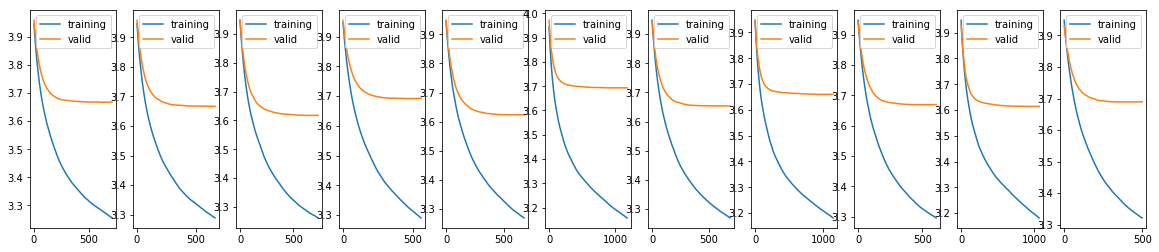

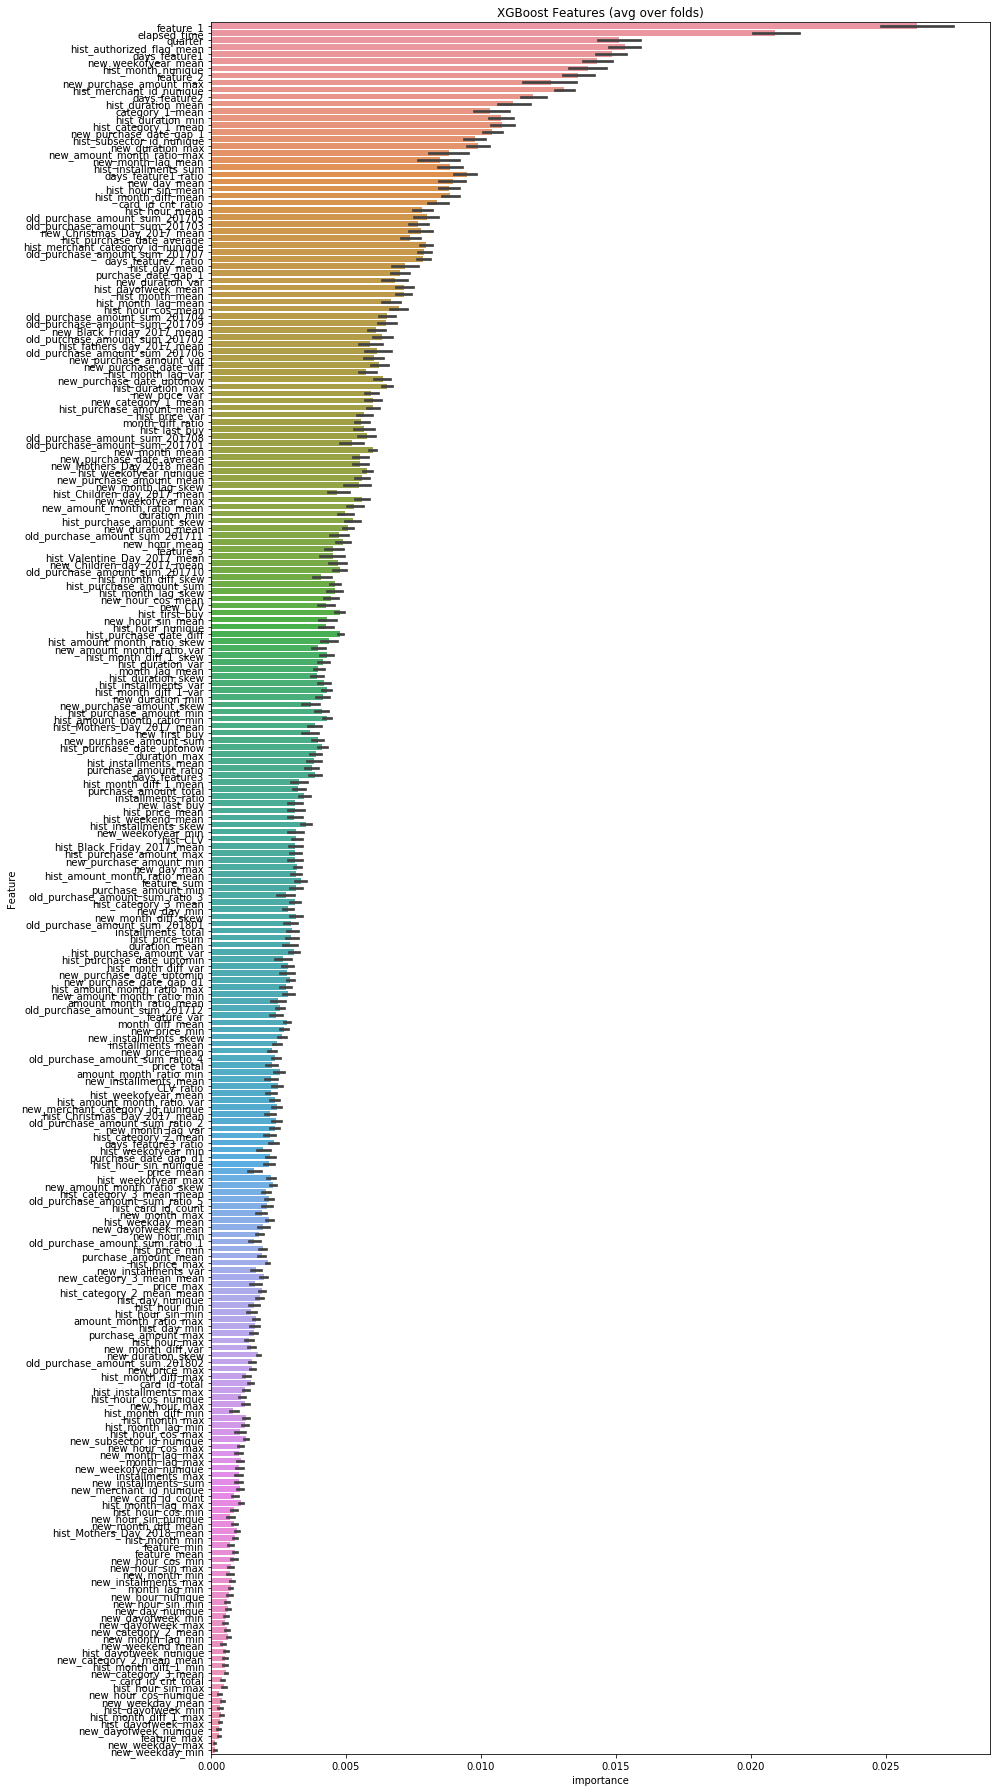

In [101]:
nowtime = datetime.datetime.now().strftime('%Y%m%d_%H%M')

kfold_xgb(df_feats_train, df_feats_test, 11)
